# ML модель для определения сахарного диабета у пациента

**Задача:** Разработать систему определяющую сахарный диабет у пациента.


**Условия для выполнения:**
- Деление на трейн и тест 70/30
- Random state - 654321
- Метрика - F1 Macro
- Метрики на train и test не должны сильно отличаться


**Описание данных**
- В датасет входит 107 колонок с различной информацией о состоянии здоровья,
 принимаемых лекарствах, различных анализах и поставленных диагнозах реальных пациентов


**План работ:**
- Загрузка данных
- Исследовательский анализ данных
- Подготовка датасета
- Создание Baseline модели
- Подбор оптимальной модели
- Проведение финального тестирования на тестовой выборке


<a id="loaddata"></a>
## 1. Загрузка данных


In [1]:
# загрузка библиотек
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from phik.report import plot_correlation_matrix

from sklearn.model_selection import (
    ShuffleSplit,
    train_test_split,
    cross_val_score,
    GridSearchCV)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (f1_score, confusion_matrix)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import ipywidgets as widgets
from IPython.display import display, clear_output

from mlxtend.plotting import plot_decision_regions
import shap
from lime import lime_tabular

import warnings
warnings.filterwarnings('ignore')




In [2]:
RANDOM_STATE = 654321

In [3]:
# загрузка данных
try:
    data = pd.read_excel('diabetes_ds.xlsx', index_col=0)
finally:
    data = pd.read_excel('./diabetes_ds.xlsx', index_col=0)

In [4]:
def first_scroll_data(data):
    '''Функция для просмотра базовой информации о
    датасете'''

    print('Общая информация:')
    print(data.info())
    print()
    print('Первые пять строк таблицы:')
    display(data.head())
    print()
    print('Последние пять строк таблицы:')
    display(data.tail())

In [5]:
first_scroll_data(data)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
Index: 484 entries, 390.0 to nan
Columns: 107 entries, Перенес/ не перенес КВИ to Сахарный диабет (ЕСТЬ\НЕТ)
dtypes: float64(100), object(7)
memory usage: 408.4+ KB
None

Первые пять строк таблицы:


Перенес/ не перенес КВИ  Возраст  Пол  Рост, см  Вес, кг  \
Номер                                                             
390.0                      1.0     68.0  2.0     158.0     86.0   
337.0                      1.0     54.0  1.0     180.0    119.0   
160.0                      1.0     68.0  1.0     174.0    110.0   
166.0                      1.0     67.0  1.0     189.0    110.0   
439.0                      1.0     60.0  1.0     178.0    115.0   

       ИМТ 2 (ФОРМУЛА EXCEL)  Эритроциты  Гемоглобин  Цветовой показатель  \
Номер                                                                       
390.0              34.449607        5.33       163.0                  0.0   
337.0              36.728395        5.01       130.0                  0.0   
160.0              36.332409         NaN       161.0                  0.0   
166.0              30.794211        4.47       134.0                  0.0   
439.0              36.295922        5.44       166.0                  0.0   

       Лейкоциты  ...  ИБС. ПИКС  ИБС. ПИКС (ЕСТЬ\НЕТ)  АГ, стадия  \
Номер             ...                                                
390.0       9.61  ...        1.0                   1.0         3.0   
337.0      10.48  ...        1.0                   1.0         3.0   
160.0       5.40  ...        1.0                   1.0         3.0   
166.0       8.50  ...        1.0                   1.0         3.0   
439.0       9.06  ...        1.0                   1.0         3.0   

       АГ (ЕСТЬ\НЕТ)  АГ, степень  АГ, риск  ХСН, стадии  ХСН, ФК  \
Номер                                                               
390.0            1.0          3.0       4.0          2.0      2.0   
337.0            1.0          3.0       4.0          2.0      3.0   
160.0            1.0          3.0       4.0          3.0      3.0   
166.0            1.0          3.0       4.0          3.0      3.0   
439.0            1.0          3.0       4.0          2.0      3.0   

       ХСН по фракции выброса, %  Сахарный диабет (ЕСТЬ\НЕТ)  
Номер                                                         
390.0                          0                         1.0  
337.0                         35                         1.0  
160.0                         35                         1.0  
166.0                          0                         1.0  
439.0                          0                         1.0  

[5 rows x 107 columns]


Последние пять строк таблицы:


Перенес/ не перенес КВИ  Возраст  Пол  Рост, см  Вес, кг  \
Номер                                                             
155.0                      2.0     47.0  2.0     168.0     58.0   
302.0                      2.0     69.0  1.0     170.0     61.0   
345.0                      2.0     62.0  1.0     175.0     75.0   
NaN                        NaN      NaN  NaN       NaN      NaN   
NaN                        NaN      NaN  NaN       NaN      NaN   

       ИМТ 2 (ФОРМУЛА EXCEL)  Эритроциты  Гемоглобин  Цветовой показатель  \
Номер                                                                       
155.0              20.549887        4.32       131.0                  0.0   
302.0              21.107266        4.40       140.0                  0.0   
345.0              24.489796        4.59       147.0                  0.0   
NaN                      NaN         NaN         NaN                  NaN   
NaN                      NaN         NaN         NaN                  NaN   

       Лейкоциты  ...  ИБС. ПИКС  ИБС. ПИКС (ЕСТЬ\НЕТ)  АГ, стадия  \
Номер             ...                                                
155.0       6.62  ...        0.0                   0.0         0.0   
302.0       6.90  ...        0.0                   0.0         0.0   
345.0       9.47  ...        0.0                   0.0         0.0   
NaN          NaN  ...        NaN                   NaN         NaN   
NaN          NaN  ...        NaN                 357.0         NaN   

       АГ (ЕСТЬ\НЕТ)  АГ, степень  АГ, риск  ХСН, стадии  ХСН, ФК  \
Номер                                                               
155.0            0.0          0.0       0.0          2.0      3.0   
302.0            0.0          1.0       0.0          2.0      2.0   
345.0            0.0          0.0       0.0          3.0      3.0   
NaN              NaN          NaN       NaN          NaN      NaN   
NaN            445.0          NaN       NaN          NaN      NaN   

       ХСН по фракции выброса, %  Сахарный диабет (ЕСТЬ\НЕТ)  
Номер                                                         
155.0                          0                         0.0  
302.0                         38                         0.0  
345.0                         35                         0.0  
NaN                          NaN                         NaN  
NaN                          NaN                         NaN  

[5 rows x 107 columns]

In [6]:
# удалим ошибочно отображенные строчки при загрузке датасте
data = data.iloc[:-2]

In [7]:
# Удалим сразу строчку с пустым таргетом
data.dropna(subset=['Сахарный диабет (ЕСТЬ\НЕТ)'],
            inplace=True)

In [8]:
# check
data['Сахарный диабет (ЕСТЬ\НЕТ)'].isna().sum()

0

In [9]:
# Отделим наши тренировочные данные от теста. Тест отложим до финального тестирования
data,test = train_test_split(
    data, test_size=0.30,
    shuffle=True, random_state=RANDOM_STATE)

In [10]:
data.shape, test.shape

((334, 107), (144, 107))

In [11]:
first_scroll_data(data)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
Index: 334 entries, 303.0 to 390.0
Columns: 107 entries, Перенес/ не перенес КВИ to Сахарный диабет (ЕСТЬ\НЕТ)
dtypes: float64(100), object(7)
memory usage: 281.8+ KB
None

Первые пять строк таблицы:


Перенес/ не перенес КВИ  Возраст  Пол  Рост, см  Вес, кг  \
Номер                                                             
303.0                      2.0     46.0  1.0     178.0     82.0   
176.0                      1.0     61.0  1.0     174.0     50.0   
438.0                      2.0     62.0  1.0     170.0     88.0   
473.0                      2.0     69.0  1.0     170.0     87.0   
226.0                      2.0     51.0  1.0     180.0     87.0   

       ИМТ 2 (ФОРМУЛА EXCEL)  Эритроциты  Гемоглобин  Цветовой показатель  \
Номер                                                                       
303.0              25.880571        4.81       154.0                  0.0   
176.0              16.514731        4.04       120.0                  0.0   
438.0              30.449827        5.10       159.0                  0.0   
473.0              30.103806        5.00       157.0                  0.0   
226.0              26.851852        4.86       124.0                  0.0   

       Лейкоциты  ...  ИБС. ПИКС  ИБС. ПИКС (ЕСТЬ\НЕТ)  АГ, стадия  \
Номер             ...                                                
303.0      12.29  ...        1.0                   1.0         0.0   
176.0      13.56  ...        0.0                   0.0         3.0   
438.0       6.20  ...        1.0                   1.0         3.0   
473.0       8.59  ...        1.0                   1.0         3.0   
226.0       8.97  ...        0.0                   0.0         3.0   

       АГ (ЕСТЬ\НЕТ)  АГ, степень  АГ, риск  ХСН, стадии  ХСН, ФК  \
Номер                                                               
303.0            0.0          0.0       0.0          2.0      2.0   
176.0            1.0          0.0       0.0          2.0      3.0   
438.0            1.0          3.0       4.0          3.0      2.0   
473.0            1.0          0.0       4.0          2.0      2.0   
226.0            1.0          3.0       4.0          2.0      2.0   

       ХСН по фракции выброса, %  Сахарный диабет (ЕСТЬ\НЕТ)  
Номер                                                         
303.0                         28                         0.0  
176.0                         36                         0.0  
438.0                         38                         0.0  
473.0                         33                         0.0  
226.0                      20-25                         1.0  

[5 rows x 107 columns]


Последние пять строк таблицы:


Перенес/ не перенес КВИ  Возраст  Пол  Рост, см  Вес, кг  \
Номер                                                             
157.0                      1.0     62.0  2.0     164.0     80.0   
247.0                      1.0     65.0  2.0     157.0     65.0   
467.0                      2.0     53.0  1.0     164.0     82.0   
159.0                      2.0     48.0  1.0     179.0     73.0   
390.0                      1.0     68.0  2.0     158.0     86.0   

       ИМТ 2 (ФОРМУЛА EXCEL)  Эритроциты  Гемоглобин  Цветовой показатель  \
Номер                                                                       
157.0              29.744200        4.59       131.0                  0.0   
247.0              26.370238        4.95       147.0                  0.0   
467.0              30.487805        5.26       148.0                  0.0   
159.0              22.783309        4.35       156.0                  0.0   
390.0              34.449607        5.33       163.0                  0.0   

       Лейкоциты  ...  ИБС. ПИКС  ИБС. ПИКС (ЕСТЬ\НЕТ)  АГ, стадия  \
Номер             ...                                                
157.0       6.53  ...        1.0                   1.0         3.0   
247.0       6.20  ...        1.0                   1.0         3.0   
467.0       6.29  ...        1.0                   1.0         3.0   
159.0       8.60  ...        1.0                   1.0         3.0   
390.0       9.61  ...        1.0                   1.0         3.0   

       АГ (ЕСТЬ\НЕТ)  АГ, степень  АГ, риск  ХСН, стадии  ХСН, ФК  \
Номер                                                               
157.0            1.0          3.0       4.0          2.0      2.0   
247.0            1.0          3.0       4.0          2.0      1.0   
467.0            1.0          3.0       4.0          3.0      3.0   
159.0            1.0          0.0       4.0          2.0      3.0   
390.0            1.0          3.0       4.0          2.0      2.0   

       ХСН по фракции выброса, %  Сахарный диабет (ЕСТЬ\НЕТ)  
Номер                                                         
157.0                         47                         0.0  
247.0                         23                         1.0  
467.0                          0                         0.0  
159.0                         39                         0.0  
390.0                          0                         1.0  

[5 rows x 107 columns]

In [12]:
# просмотрим пропуски в датасете
display(pd.DataFrame(round(
        data.isna().mean()*100,)).T.style.background_gradient(
        'coolwarm', axis=1))

In [13]:
first_scroll_data(test)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 52.0 to 181.0
Columns: 107 entries, Перенес/ не перенес КВИ to Сахарный диабет (ЕСТЬ\НЕТ)
dtypes: float64(100), object(7)
memory usage: 121.5+ KB
None

Первые пять строк таблицы:


Перенес/ не перенес КВИ  Возраст  Пол  Рост, см  Вес, кг  \
Номер                                                             
52.0                       2.0     51.0  1.0     172.0    103.0   
33.0                       1.0     69.0  1.0     181.0     75.0   
250.0                      1.0     65.0  1.0     187.0    120.0   
50.0                       2.0     53.0  1.0     176.0     95.0   
3.0                        1.0     69.0  2.0     163.0     94.0   

       ИМТ 2 (ФОРМУЛА EXCEL)  Эритроциты  Гемоглобин  Цветовой показатель  \
Номер                                                                       
52.0               34.816117        4.70       145.0                  0.0   
33.0               22.893074        5.02       156.0                  0.0   
250.0              34.316109        4.20       140.0                  0.0   
50.0               30.668905        4.83       157.0                  0.0   
3.0                35.379578        4.00       120.0                  0.0   

       Лейкоциты  ...  ИБС. ПИКС  ИБС. ПИКС (ЕСТЬ\НЕТ)  АГ, стадия  \
Номер             ...                                                
52.0        7.57  ...        1.0                   1.0         3.0   
33.0        7.93  ...        1.0                   1.0         3.0   
250.0       5.00  ...        0.0                   0.0         3.0   
50.0       11.68  ...        1.0                   1.0         3.0   
3.0         5.30  ...        1.0                   1.0         3.0   

       АГ (ЕСТЬ\НЕТ)  АГ, степень  АГ, риск  ХСН, стадии  ХСН, ФК  \
Номер                                                               
52.0             1.0          3.0       4.0          2.0      2.0   
33.0             1.0          2.0       4.0          2.0      2.0   
250.0            1.0          3.0       4.0          3.0      3.0   
50.0             1.0          0.0       4.0          3.0      3.0   
3.0              1.0          3.0       4.0          2.0      2.0   

       ХСН по фракции выброса, %  Сахарный диабет (ЕСТЬ\НЕТ)  
Номер                                                         
52.0                          35                         1.0  
33.0                       30-31                         0.0  
250.0                         35                         1.0  
50.0                          32                         1.0  
3.0                           32                         0.0  

[5 rows x 107 columns]


Последние пять строк таблицы:


Перенес/ не перенес КВИ  Возраст  Пол  Рост, см  Вес, кг  \
Номер                                                             
130.0                      1.0     62.0  1.0     178.0    100.0   
453.0                      2.0     48.0  1.0     190.0    103.0   
297.0                      1.0     62.0  1.0     185.0    140.0   
464.0                      1.0     70.0  1.0     182.0    100.0   
181.0                      1.0     70.0  1.0     172.0     75.0   

       ИМТ 2 (ФОРМУЛА EXCEL)  Эритроциты  Гемоглобин  Цветовой показатель  \
Номер                                                                       
130.0              31.561672       5.430       153.0                  0.0   
453.0              28.531856       5.122       156.0                  0.0   
297.0              40.905771       5.170       160.0                  0.0   
464.0              30.189591       4.800       133.0                  0.0   
181.0              25.351541       5.280       138.0                  0.0   

       Лейкоциты  ...  ИБС. ПИКС  ИБС. ПИКС (ЕСТЬ\НЕТ)  АГ, стадия  \
Номер             ...                                                
130.0       7.12  ...        1.0                   1.0         3.0   
453.0       7.02  ...        0.0                   0.0         3.0   
297.0       7.99  ...        1.0                   1.0         3.0   
464.0       6.50  ...        1.0                   1.0         3.0   
181.0       8.04  ...        1.0                   1.0         3.0   

       АГ (ЕСТЬ\НЕТ)  АГ, степень  АГ, риск  ХСН, стадии  ХСН, ФК  \
Номер                                                               
130.0            1.0          3.0       4.0          2.0      2.0   
453.0            1.0          3.0       4.0          2.0      2.0   
297.0            1.0          3.0       4.0          2.0      2.0   
464.0            1.0          3.0       4.0          3.0      2.0   
181.0            1.0          2.0       4.0          3.0      3.0   

       ХСН по фракции выброса, %  Сахарный диабет (ЕСТЬ\НЕТ)  
Номер                                                         
130.0                         40                         0.0  
453.0                         21                         1.0  
297.0                         40                         1.0  
464.0                         46                         1.0  
181.0                         24                         0.0  

[5 rows x 107 columns]

In [14]:
# посмотрим пропуски в тесте
display(pd.DataFrame(round(
        test.isna().mean()*100,)).T.style.background_gradient(
        'coolwarm', axis = 1))

**Вывод:** Загружены библиотеки и датасет. В датасете обнаружено большое кол-во пропусков, сам датасет состоит из 107 колонок и 484 строчек. От датасета была отделена часть для проведения тестирования.

<a id="start_eda"></a>
## 2. Исследовательский анализ данных

Подготовим датасет, удалив все пропуски <= 5%. Колонки с пропусками больше 20% заполним значениями-заглушками, если пропусков меньше - заполним медианным значением в колонке. Из-датасета будут удалены дублирующиеся значения, а также все колонки обозначающие употребление лекарственных препаратов пациентом.

In [15]:
# сейв изначального датасета
data_eda_1 = data.copy()

In [16]:
def scroll_unique(data):
    '''Функция для отображения уникальных
    значений и их кол-венное распределение'''
    for i in data.columns:
        print()
        print(data[i].unique())
        print(data[i].value_counts())

In [ ]:
scroll_unique(data_eda_1)

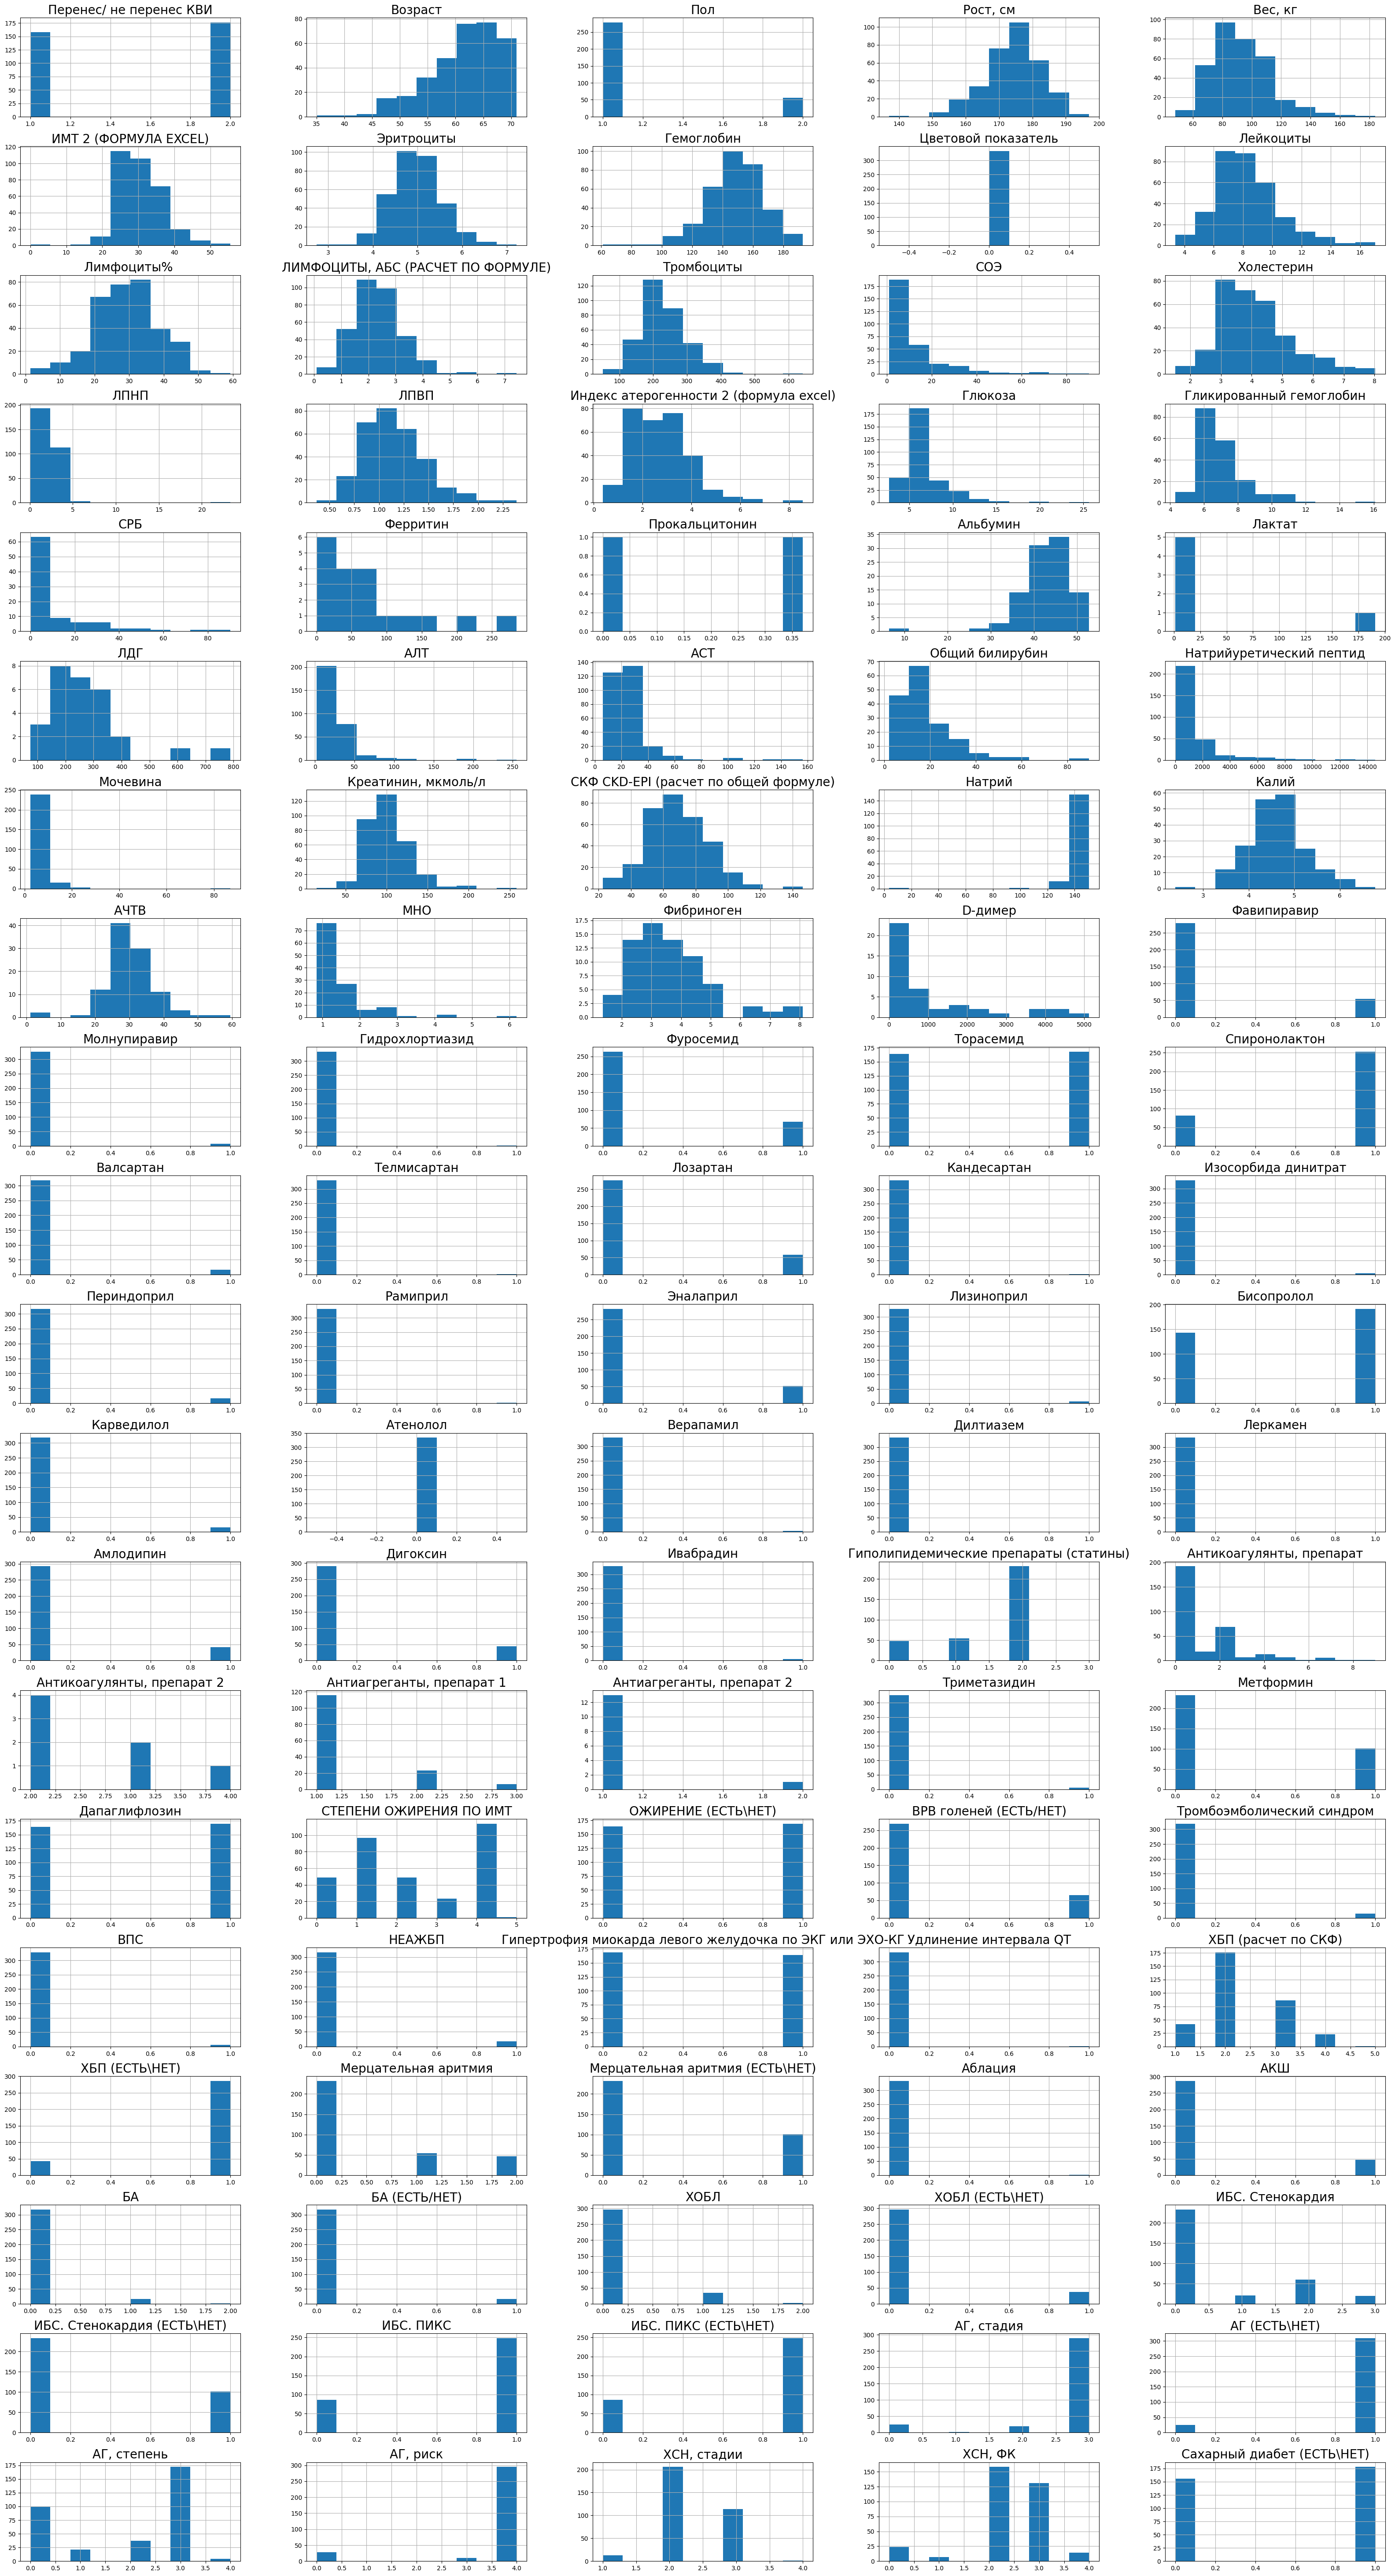

In [18]:
# построение гистограм (дублирование просмотра дисбаланса значений в колонках)

params = {'axes.titlesize': 20}
plt.rcParams.update(params)
data_eda_1.hist(figsize=(40, 75), layout=(20, 5))
plt.show()

<Figure size 2000x2000 with 0 Axes>

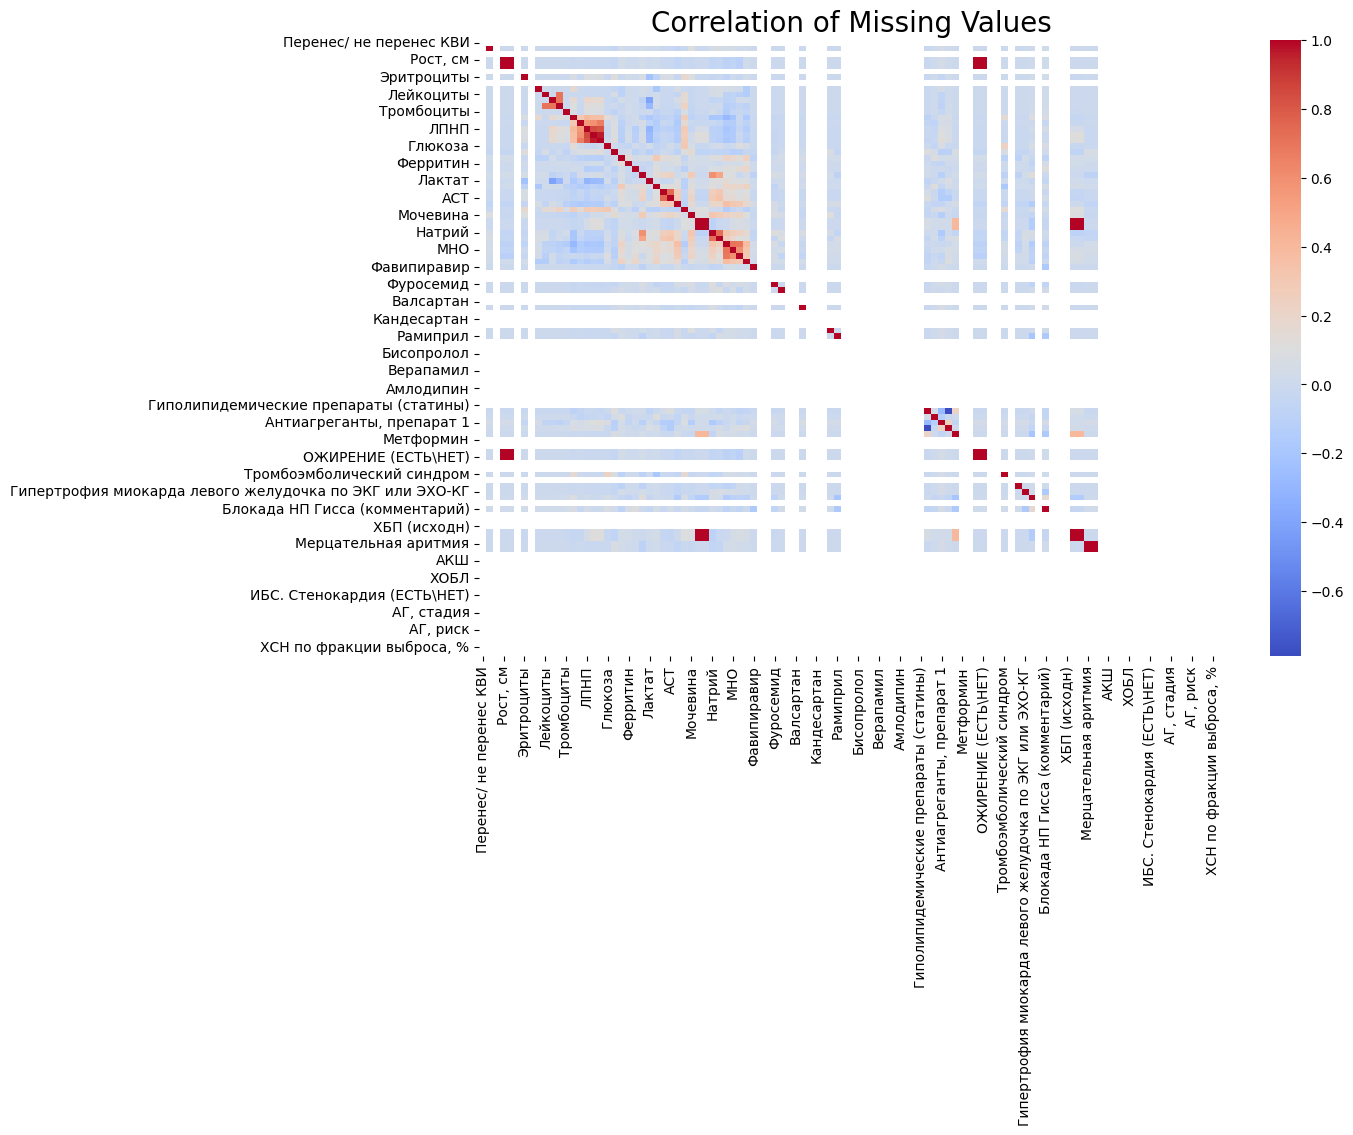

In [19]:
# корреляция между колонками с пропусками
plt.figure(figsize=(20, 20))

missing_corr = data_eda_1.isnull().corr()

plt.figure(figsize=(12, 8))
sns.heatmap(missing_corr, annot=False, cmap="coolwarm")
plt.title("Correlation of Missing Values")
plt.show()

**Вывод:** В датасете обнаружено большое кол-во дисбаланса между значениями. Также заметна корреляция между между пропусками: чаще всего не заполняются результата анализа крови.

In [20]:
# колонки с черезмерными дизбалансом классов.
# в основном это лекарственные препараты
data_eda_1=data_eda_1.drop(
    ['Цветовой показатель', 'Молнупиравир',
     'Гидрохлортиазид', 'Валсартан', 'Телмисартан', 'Кандесартан',
     'Изосорбида динитрат', 'Периндоприл', 'Рамиприл',
     'Лизиноприл', 'Карведилол', 'Атенолол',
     'Верапамил', 'Дилтиазем', 'Леркамен',
     'Ивабрадин', 'Триметазидин', 'ВПС' , 'НЕАЖБП',
     'Удлинение интервала QT', 'Аблация', 'Метформин',
     'Дапаглифлозин', 'Триметазидин', 'Дигоксин',
     'Амлодипин', 'Бисопролол', 'Эналаприл', 'Рамиприл',
     'Периндоприл', 'Изосорбида динитрат', 'Лозартан',
     'Спиронолактон', 'Торасемид', 'Фуросемид',
     'Фавипиравир', 'Гликированный гемоглобин'], axis=1)

In [21]:
# удаление излишних информационных колонок
data_eda_1 = data_eda_1.drop(
    ['Блокада НП Гисса (комментарий)', 
     'Гипертрофия миокарда левого желудочка по ЭКГ или ЭХО-КГ (комментарий)'],
    axis=1)

# удаление колонок, которые дублируют информацию
data_eda_1 = data_eda_1.drop(
    ['БА (ЕСТЬ/НЕТ)', 'ХОБЛ (ЕСТЬ\НЕТ)',
     'ИБС. Стенокардия (ЕСТЬ\НЕТ)', 'ИБС. ПИКС (ЕСТЬ\НЕТ)',
     'АГ (ЕСТЬ\НЕТ)', 'ХБП (ЕСТЬ\НЕТ)', 'Мерцательная аритмия (ЕСТЬ\НЕТ)',
     'ОЖИРЕНИЕ (ЕСТЬ\НЕТ)', 'BPB голеней (ЕСТЬ/НЕТ)',
     'Антикоагулянты, препарат 2', 'Антиагреганты, препарат 2'], axis=1)

# удаление колонок, пропуски в которых трудно восстановить
data_eda_1 = data_eda_1.drop(
    ['СРБ', 'Ферритин',
     'Прокальцитонин', 'Альбумин',
     'Лактат', 'АЧТВ' ,'ЛДГ',
     'МНО', 'Фибриноген', 'D-димер'], axis=1)

# удаление неинформативных колонок
data_eda_1 = data_eda_1.drop(
    ['АГ, стадия', 'АГ, риск',
     'ХСН, ФК', 'ХБП (расчет по СКФ)',
     'Рост, см', 'Вес, кг'], axis=1)

In [22]:
# заполним пропуски значением 0 т.к. это терапия, и если нет препаратов значит они не назначались
data_eda_1['Антикоагулянты, препарат'] = data_eda_1[
    'Антикоагулянты, препарат'].fillna(0)
data_eda_1['Антиагреганты, препарат 1'] = data_eda_1[
    'Антиагреганты, препарат 1'].fillna(0)

In [23]:
data_eda_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 334 entries, 303.0 to 390.0
Data columns (total 45 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Перенес/ не перенес КВИ                                  334 non-null    float64
 1   Возраст                                                  333 non-null    float64
 2   Пол                                                      334 non-null    float64
 3   ИМТ 2 (ФОРМУЛА EXCEL)                                    334 non-null    float64
 4   Эритроциты                                               331 non-null    float64
 5   Гемоглобин                                               334 non-null    float64
 6   Лейкоциты                                                333 non-null    float64
 7   Лимфоциты%                                               333 non-null    float64
 8   ЛИМФОЦИТЫ, АБС (РАСЧЕТ ПО ФОР

**Вывод:** После подробного изучения датасета было решено сократить часть неинформативных колонок. В итоге на данный момент датасет состоит уже из 45 колонок (т.е. датасет был сокращен более чем в 2 раза)

In [24]:
# заменим значения, которые были записаны не верно
data_eda_1['BPB голеней'] = data_eda_1['BPB голеней'].replace({'2-3': 2})
data_eda_1['Блокада НП Гисса'] = data_eda_1['Блокада НП Гисса'].replace(
    {'1-2': 2})
data_eda_1['AV- блокада'] = data_eda_1['AV- блокада'].replace(
    {'полная': 3, '1-2': 1, '2-3': 3})
data_eda_1['ХБП (исходн)'] = data_eda_1['ХБП (исходн)'].replace(
    {'с3а-с3б': 'c3a', 'с2-с3': 'c2', '2са1': 'c2','с1 а3': 'c1'})
data_eda_1['Перенес/ не перенес КВИ'] = data_eda_1['Перенес/ не перенес КВИ'].replace(
    {1: 0, 2: 1})

# произведем сокращение классов и кодирование в данной колонке
data_eda_1['ХБП (исходн)'] = data_eda_1['ХБП (исходн)'].replace(
    {'с3а-с3б': 'c3a', 'с2-с3': 'c2', '2са1': 'c2', 'с1 а3': 'c1'})
data_eda_1['ХБП (исходн)'] = data_eda_1['ХБП (исходн)'].replace(
    {'с1': 1, 'c1': 1, 'c2': 2, 'с2': 2, '2а': 3,
     'с3': 4, 'с3а': 5, 'c3a': 5, 'с3a': 5,'с3б': 6, 'с4': 7})

data_eda_1['Сахарный диабет (ЕСТЬ\НЕТ)'] = data_eda_1['Сахарный диабет (ЕСТЬ\НЕТ)'].astype('int')
data_eda_1['Блокада НП Гисса'] = data_eda_1['Блокада НП Гисса'].astype('int')
data_eda_1['AV- блокада'] = data_eda_1['AV- блокада'].astype('int')
data_eda_1['ХБП (исходн)'] = data_eda_1['ХБП (исходн)'].astype('int')
data_eda_1['Перенес/ не перенес КВИ'] = data_eda_1['Перенес/ не перенес КВИ'].astype('int')
data_eda_1['АКШ'] = data_eda_1['АКШ'].astype('int')


In [25]:
def clean_value(val):
    '''Функция для замены значений из колонки из числового
    (по типу "35-45") на 40'''
    try:
        return float(val)
    except ValueError:
        pass
    try:
        parts = val.split('-')
        if len(parts) == 2:
            return (float(parts[0]) + float(parts[1])) / 2
    except ValueError:
        pass
    return 0

# Применение функции clean_value к каждому элементу
data_eda_1['ХСН по фракции выброса, %'] = np.array([clean_value(val) for val in data_eda_1['ХСН по фракции выброса, %']])
data_eda_1['ХСН по фракции выброса, %'] = data_eda_1['ХСН по фракции выброса, %'].astype('float')

In [26]:
# проверим что ошибочных переменных больше не осталось
scroll_unique(data_eda_1)


[1 0]
Перенес/ не перенес КВИ
1    176
0    158
Name: count, dtype: int64

[46. 61. 62. 69. 51. 66. 68. 65. 71. 55. 60. 67. 64. 59. 49. 45. 58. 63.
 50. 54. 52. 56. 35. 48. 70. 57. 41. nan 53. 47.]
Возраст
62.0    29
65.0    25
69.0    24
63.0    24
61.0    23
68.0    23
66.0    22
64.0    17
60.0    15
58.0    14
67.0    13
59.0    13
55.0    12
56.0    12
70.0    11
50.0     7
49.0     7
71.0     6
51.0     6
57.0     6
53.0     4
46.0     4
52.0     4
54.0     4
48.0     3
45.0     2
35.0     1
41.0     1
47.0     1
Name: count, dtype: int64

[1. 2.]
Пол
1.0    278
2.0     56
Name: count, dtype: int64

[25.88057064 16.51473114 30.44982699 30.10380623 26.85185185 31.22130395
 32.59637188 30.0232438  35.51136364 32.38835543 33.77098851 37.20238095
 35.64013841 42.2405877  24.67105263 30.77870114 20.9839876  36.29592223
 30.18959063 32.03857841 27.46481071 30.48668503 39.44207394 24.8357635
 27.77427093 21.29529475 24.91349481 30.11621315 26.21882086 26.171875
 26.8744961  27.54820937

In [27]:
# сделаем сейф датасета
data_eda_1v1 = data_eda_1.copy()

In [28]:
display(pd.DataFrame(round(
        data_eda_1v1.isna().mean()*100,)).T.style.background_gradient(
        'coolwarm', axis = 1))

In [29]:
# удаляем пропуски меньше 5%
data_eda_1v1.dropna(
    subset=['Возраст', 'Эритроциты', 'Лейкоциты',
            'Лимфоциты% ', 'ЛИМФОЦИТЫ, АБС (РАСЧЕТ ПО ФОРМУЛЕ)',
            'Тромбоциты', 'Креатинин, мкмоль/л',
            'СКФ CKD-EPI (расчет по общей формуле)',
            'СТЕПЕНИ ОЖИРЕНИЯ ПО ИМТ', 'BPB голеней',
            'Тромбоэмболический синдром',
            'Гипертрофия миокарда левого желудочка по ЭКГ или ЭХО-КГ',
            'Мерцательная аритмия', 'ХСН по фракции выброса, %'], inplace=True)

In [30]:
# Пропуски до 20% заполним медианными значениями
to_median=['СОЭ', 'Холестерин', 'ЛПНП',
            'ЛПВП', 'Индекс атерогенности 2 (формула excel)',
            'Глюкоза', 'АЛТ', 'АСТ', 'Натрийуретический пептид', ]

for i in to_median:
    data_eda_1v1.loc[data_eda_1v1[i].isna(), i] = data_eda_1v1.loc[
        data_eda_1v1[i].notna(), i].median()


In [31]:
# остальные пропуски закроем заглушками
to_except = ['Натрий', 'Калий', 'Мочевина', 'Общий билирубин']
for i in to_except:
    data_eda_1v1.loc[data_eda_1v1[i].isna(), i] = 0


In [32]:
# скорректируем после заполнения пропусков тип данных
data_eda_1v1['Тромбоэмболический синдром'] = \
    data_eda_1v1['Тромбоэмболический синдром'].astype('int')
data_eda_1v1['Гипертрофия миокарда левого желудочка по ЭКГ или ЭХО-КГ']= \
    data_eda_1v1['Гипертрофия миокарда левого желудочка по ЭКГ или ЭХО-КГ'].astype('int')

In [33]:
data_eda_1v1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 315 entries, 303.0 to 390.0
Data columns (total 45 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Перенес/ не перенес КВИ                                  315 non-null    int64  
 1   Возраст                                                  315 non-null    float64
 2   Пол                                                      315 non-null    float64
 3   ИМТ 2 (ФОРМУЛА EXCEL)                                    315 non-null    float64
 4   Эритроциты                                               315 non-null    float64
 5   Гемоглобин                                               315 non-null    float64
 6   Лейкоциты                                                315 non-null    float64
 7   Лимфоциты%                                               315 non-null    float64
 8   ЛИМФОЦИТЫ, АБС (РАСЧЕТ ПО ФОР

**Вывод:** Тренировочный дадастет после заполнения пропусковс содержит 315 строчек данных и 44 колонки. Теперь можно провести подробное исследование имеющихся данных.

### Начало подробного EDA

interval columns not set, guessing: ['Перенес/ не перенес КВИ', 'Возраст', 'Пол', 'ИМТ 2 (ФОРМУЛА EXCEL)', 'Эритроциты', 'Гемоглобин', 'Лейкоциты', 'Лимфоциты% ', 'ЛИМФОЦИТЫ, АБС (РАСЧЕТ ПО ФОРМУЛЕ)', 'Тромбоциты', 'СОЭ', 'Холестерин', 'ЛПНП', 'ЛПВП', 'Индекс атерогенности 2 (формула excel)', 'Глюкоза', 'АЛТ', 'АСТ', 'Общий билирубин', 'Натрийуретический пептид', 'Мочевина', 'Креатинин, мкмоль/л', 'СКФ CKD-EPI (расчет по общей формуле)', 'Натрий', 'Калий', 'Гиполипидемические препараты (статины)', 'Антикоагулянты, препарат', 'Антиагреганты, препарат 1', 'СТЕПЕНИ ОЖИРЕНИЯ ПО ИМТ', 'BPB голеней', 'Тромбоэмболический синдром', 'Гипертрофия миокарда левого желудочка по ЭКГ или ЭХО-КГ', 'Блокада НП Гисса', 'AV- блокада', 'ХБП (исходн)', 'Мерцательная аритмия', 'АКШ', 'БА', 'ХОБЛ', 'ИБС. Стенокардия', 'ИБС. ПИКС', 'АГ, степень', 'ХСН, стадии', 'ХСН по фракции выброса, %', 'Сахарный диабет (ЕСТЬ\\НЕТ)']


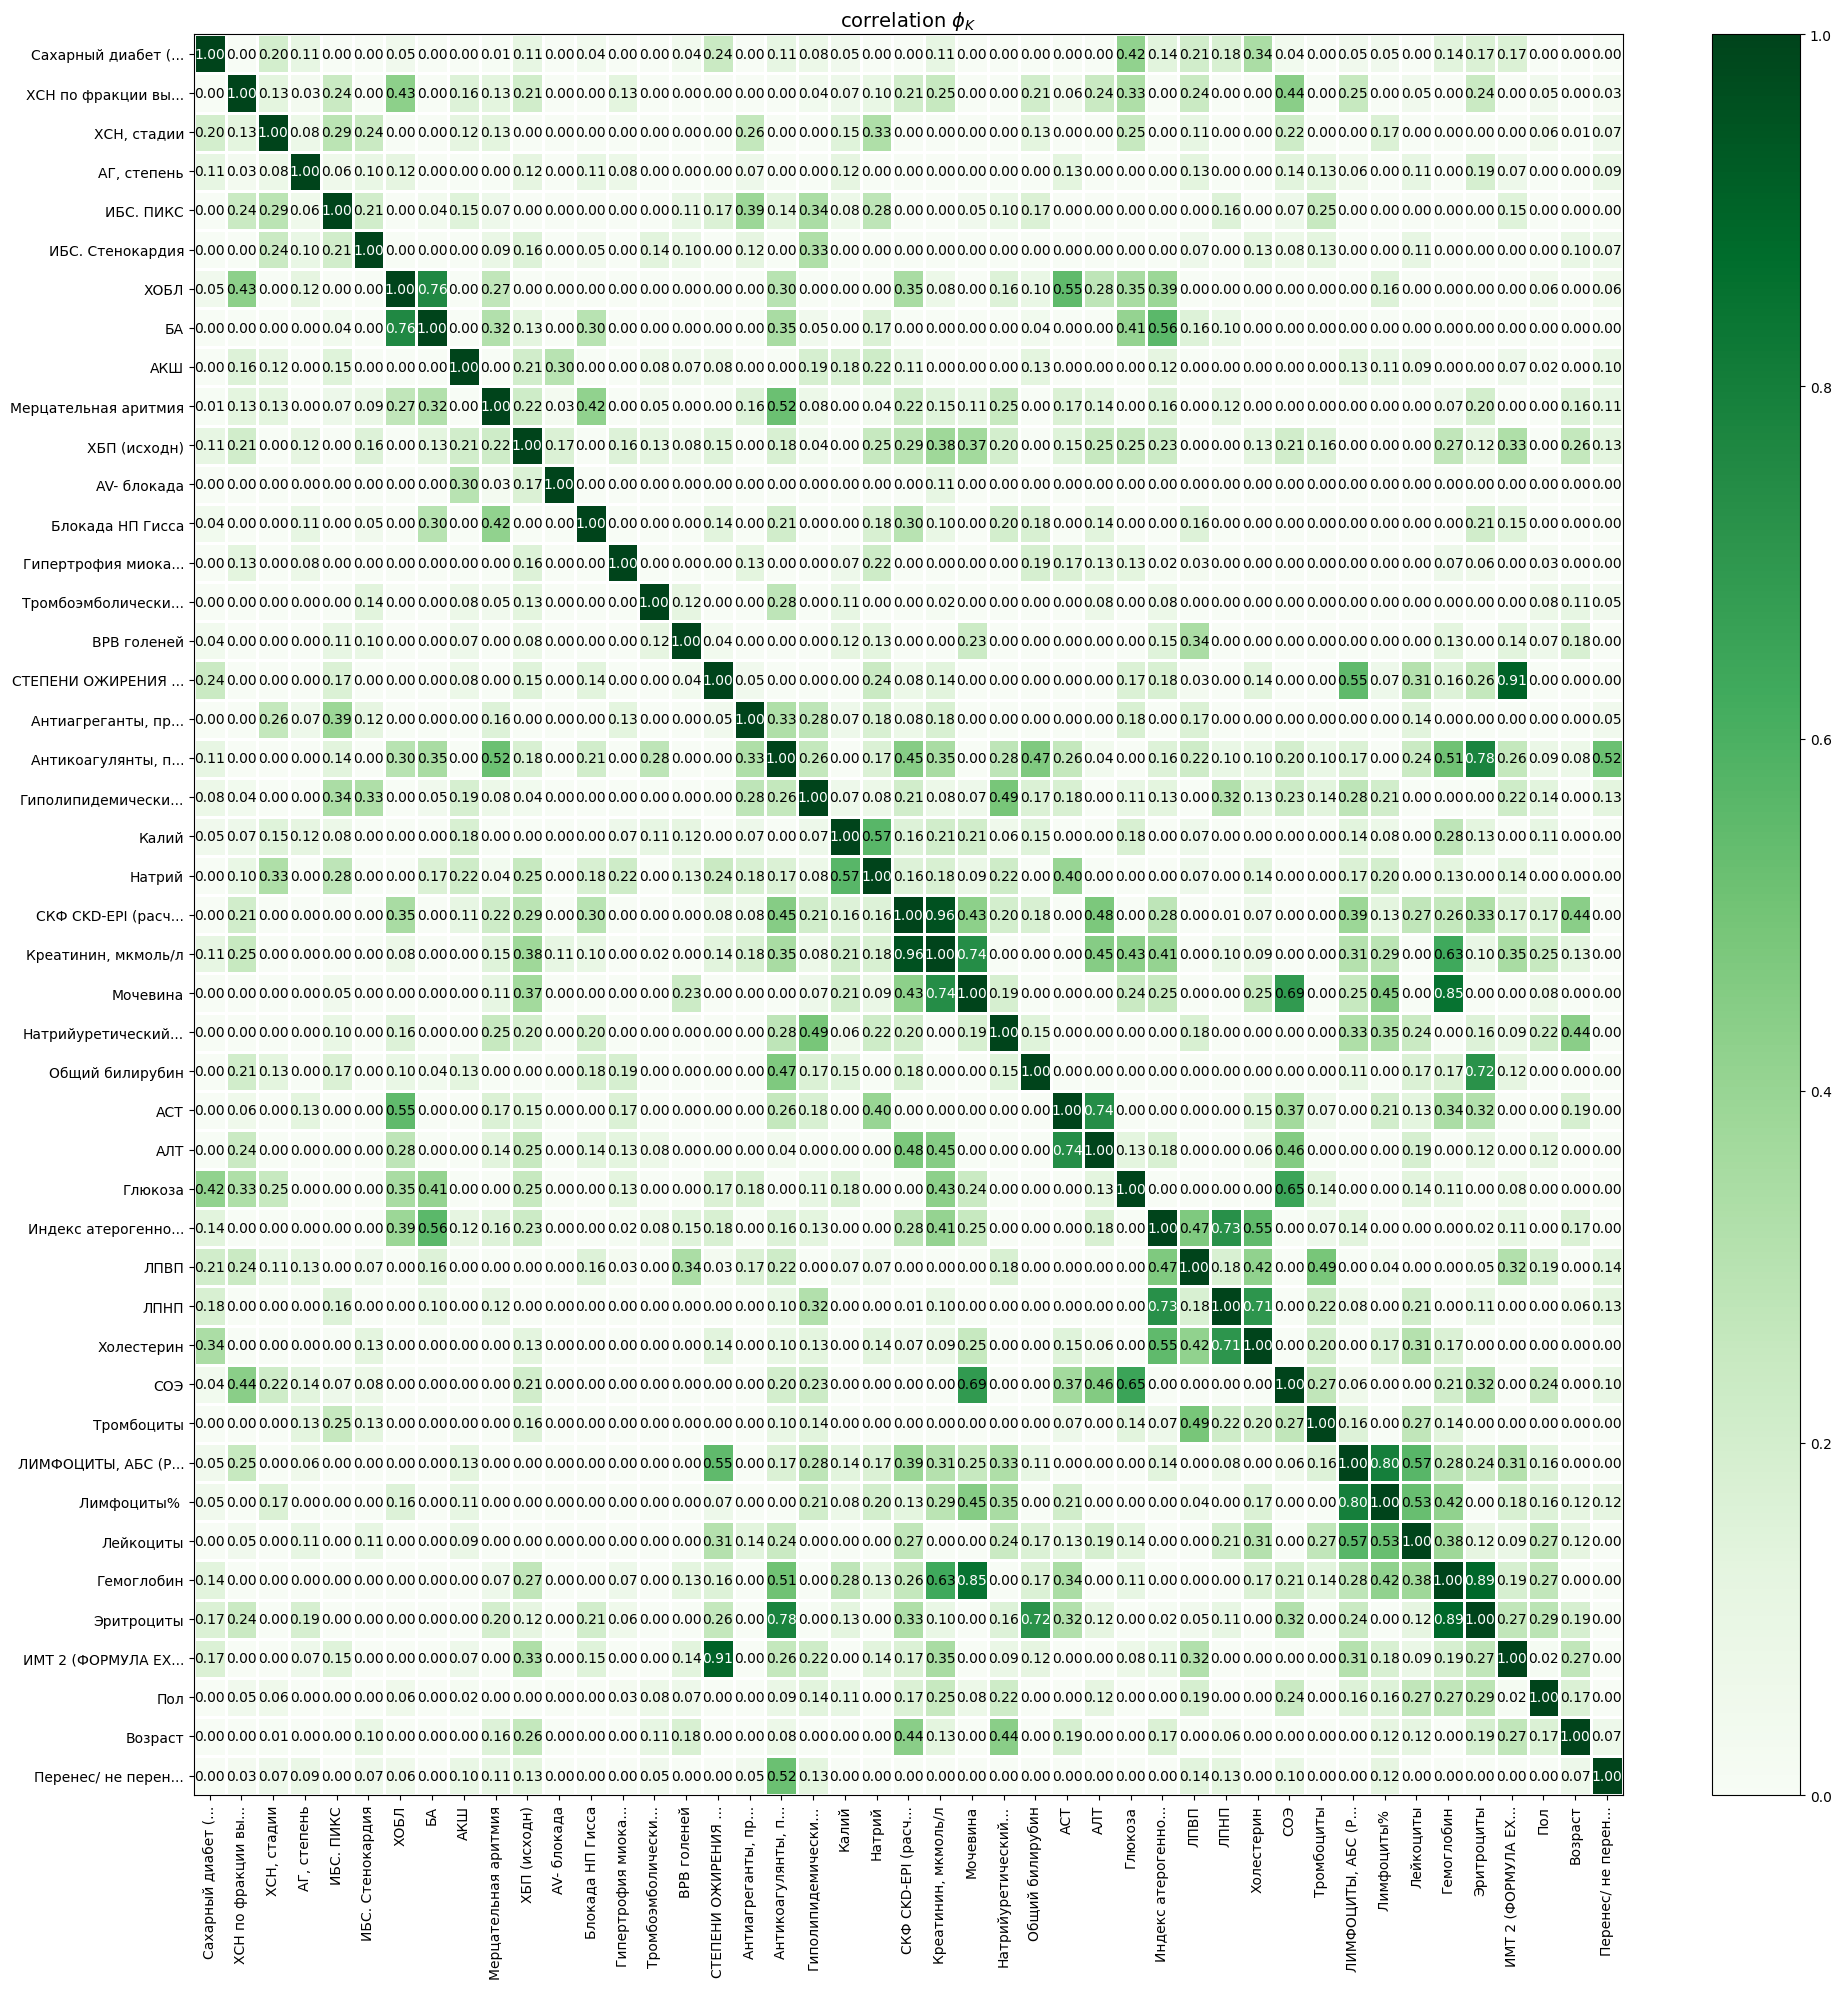

In [34]:
# построим матрицу корреляции что бы оценить взаимосвязь признаков и таргета
phik_overview = data_eda_1v1.phik_matrix()

plot_correlation_matrix(phik_overview.values.round(2),
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=1,
                        figsize=(20, 20))
plt.tight_layout()

**Вывод:** Замечено, что очень много осталось ещё колонок, корреляция которых с таргетом очень мала. Решено сократить кол-во данных колонок

In [35]:
# сделаем сейф
data_eda_1v1_drop = data_eda_1v1.copy()

In [36]:
# удалим колонки, у которых корреляция с таргетом отсутствует

data_eda_1v1_drop = data_eda_1v1_drop.drop(
    ['Возраст', 'Пол', 'Лимфоциты% ', 'АСТ', 'АЛТ',
     'Натрийуретический пептид', 'СКФ CKD-EPI (расчет по общей формуле)',
     'Антиагреганты, препарат 1', 'BPB голеней',
     'ИБС. ПИКС', 'ХСН по фракции выброса, %',
     'Антикоагулянты, препарат', 'Гиполипидемические препараты (статины)'], axis=1)

interval columns not set, guessing: ['Перенес/ не перенес КВИ', 'ИМТ 2 (ФОРМУЛА EXCEL)', 'Эритроциты', 'Гемоглобин', 'Лейкоциты', 'ЛИМФОЦИТЫ, АБС (РАСЧЕТ ПО ФОРМУЛЕ)', 'Тромбоциты', 'СОЭ', 'Холестерин', 'ЛПНП', 'ЛПВП', 'Индекс атерогенности 2 (формула excel)', 'Глюкоза', 'Общий билирубин', 'Мочевина', 'Креатинин, мкмоль/л', 'Натрий', 'Калий', 'СТЕПЕНИ ОЖИРЕНИЯ ПО ИМТ', 'Тромбоэмболический синдром', 'Гипертрофия миокарда левого желудочка по ЭКГ или ЭХО-КГ', 'Блокада НП Гисса', 'AV- блокада', 'ХБП (исходн)', 'Мерцательная аритмия', 'АКШ', 'БА', 'ХОБЛ', 'ИБС. Стенокардия', 'АГ, степень', 'ХСН, стадии', 'Сахарный диабет (ЕСТЬ\\НЕТ)']


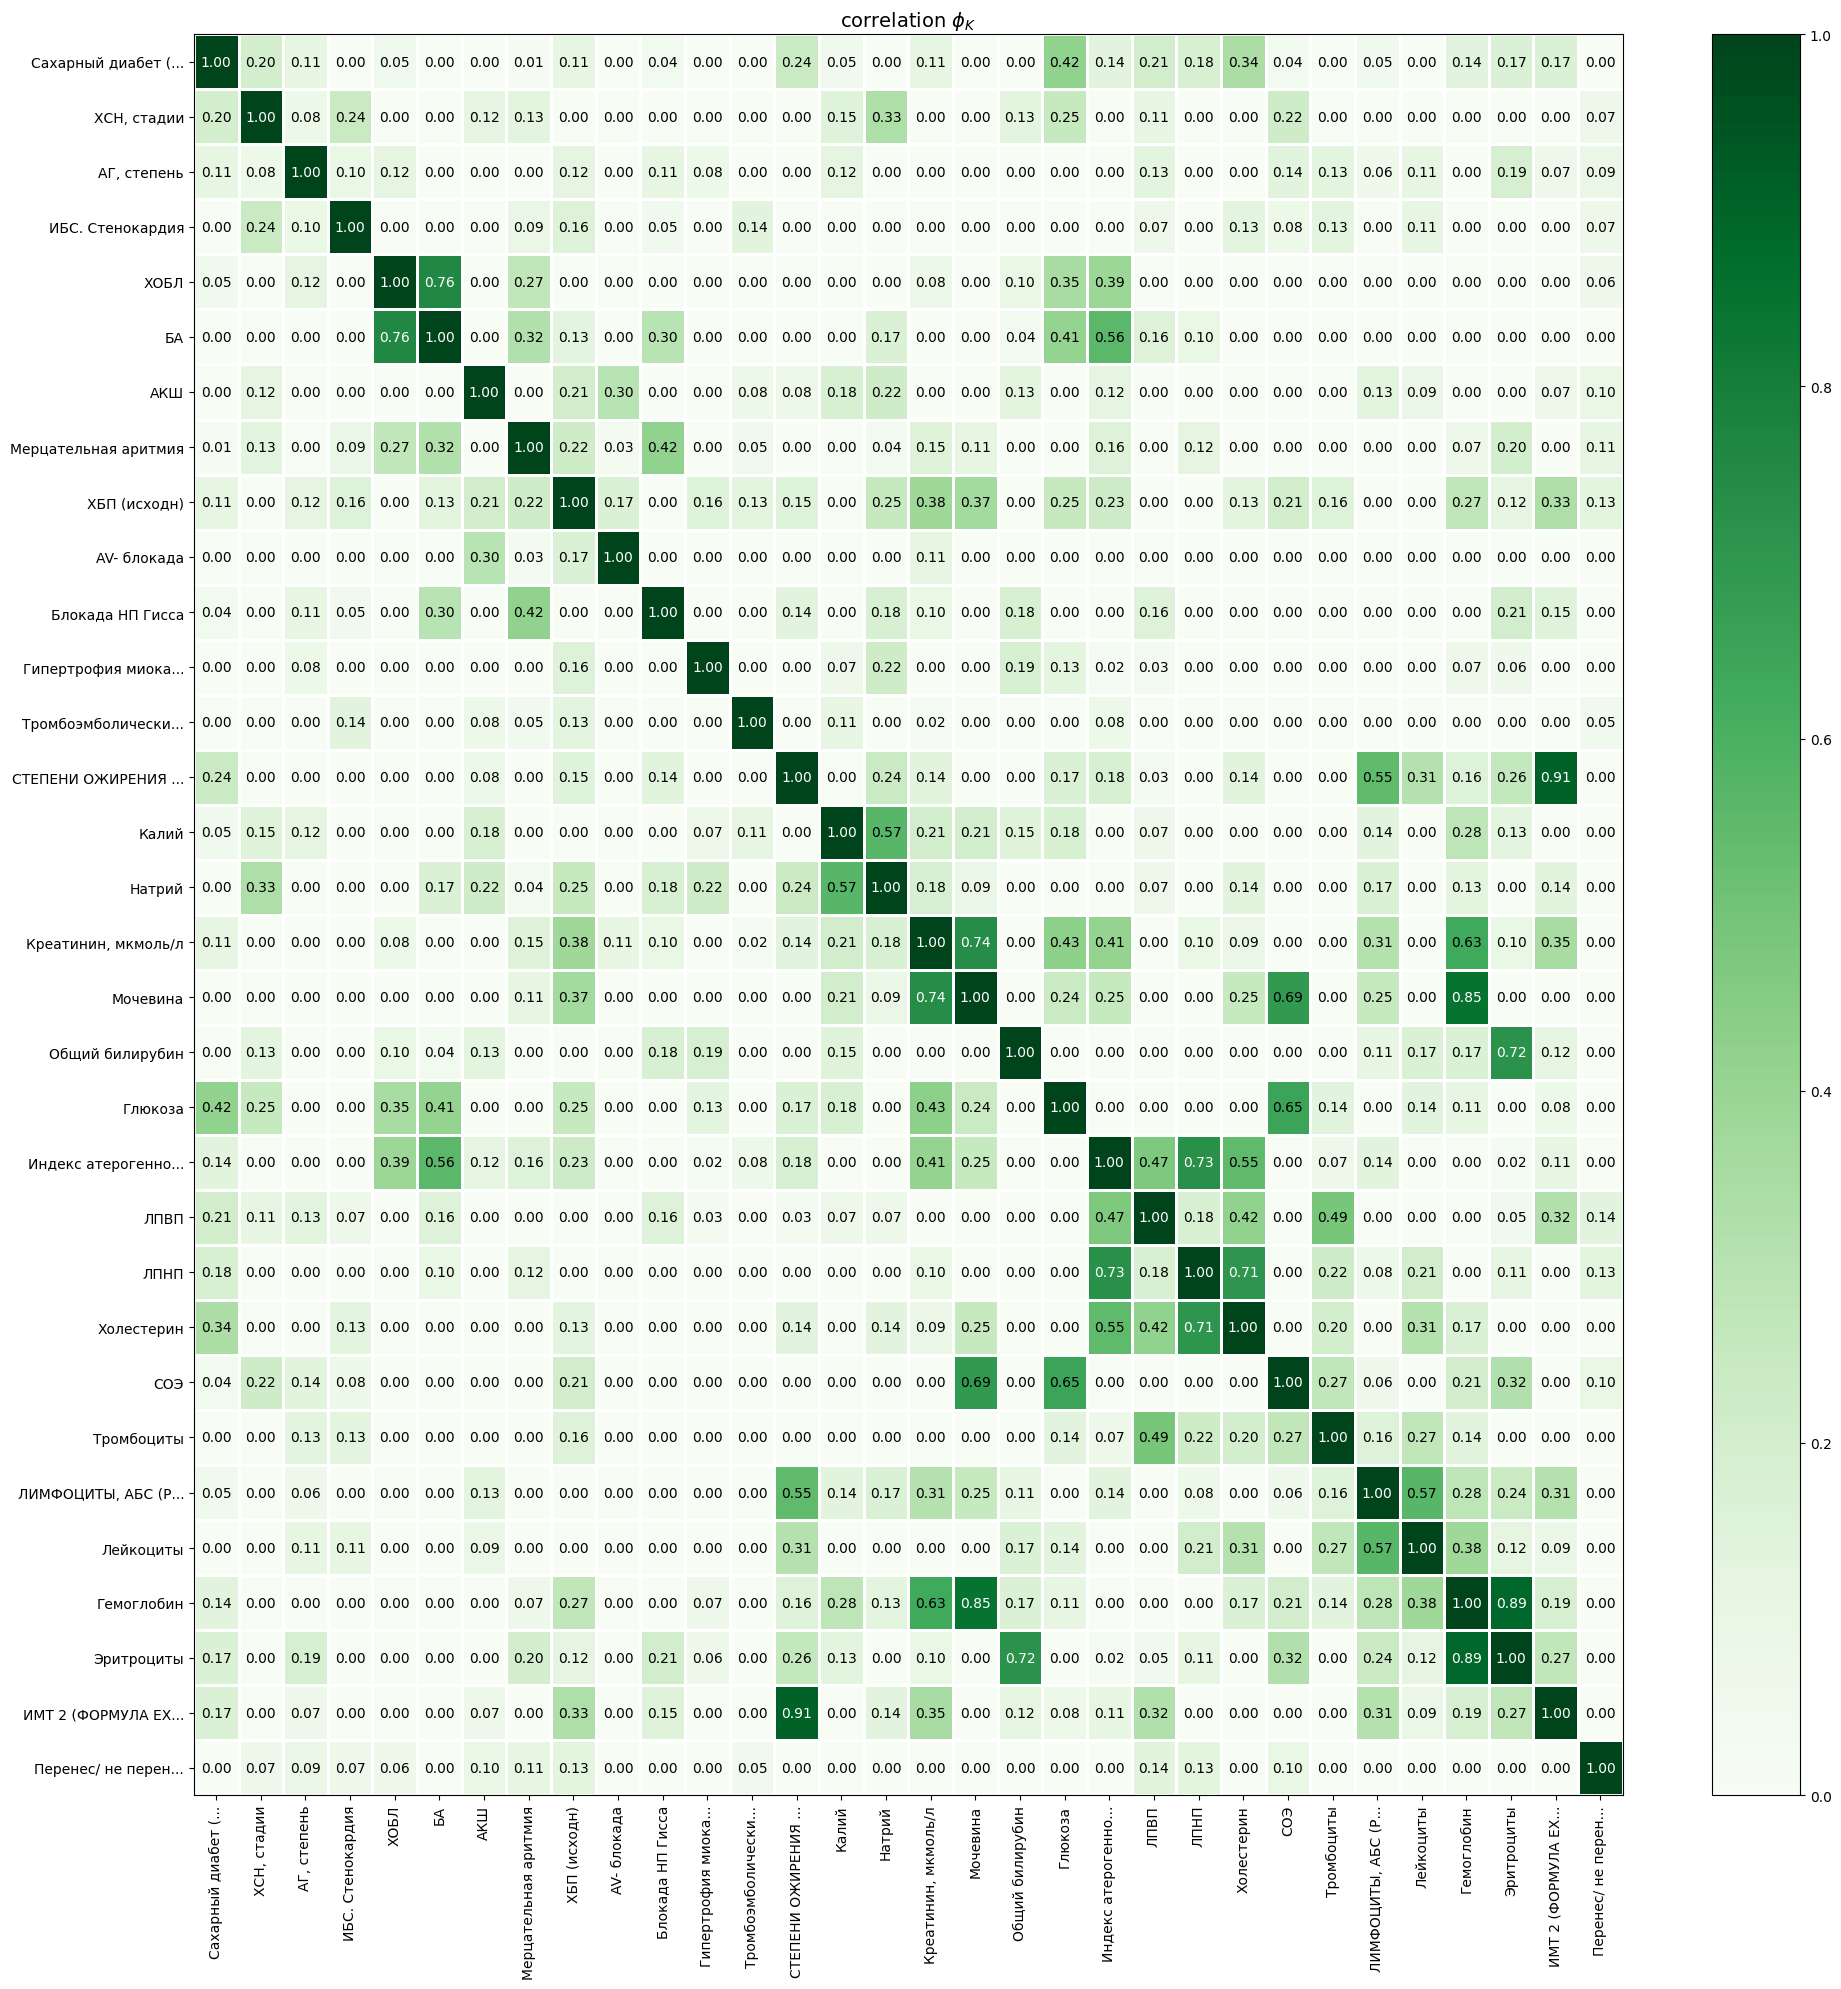

In [37]:
# повторно построим матрицу корреляции
phik_overview = data_eda_1v1_drop.phik_matrix()

plot_correlation_matrix(phik_overview.values.round(2),
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=1,
                        figsize=(20, 20))
plt.tight_layout()

In [38]:
data_eda_1v1_drop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 315 entries, 303.0 to 390.0
Data columns (total 32 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Перенес/ не перенес КВИ                                  315 non-null    int64  
 1   ИМТ 2 (ФОРМУЛА EXCEL)                                    315 non-null    float64
 2   Эритроциты                                               315 non-null    float64
 3   Гемоглобин                                               315 non-null    float64
 4   Лейкоциты                                                315 non-null    float64
 5   ЛИМФОЦИТЫ, АБС (РАСЧЕТ ПО ФОРМУЛЕ)                       315 non-null    float64
 6   Тромбоциты                                               315 non-null    float64
 7   СОЭ                                                      315 non-null    float64
 8   Холестерин                   

**Вывод:** По итогу датасет был сокращено ещё до 32 колонок.

In [39]:
def base_graph(data, column):
    """Функция для отрисовки describe boxplot heatmap и hist"""

    '''Отрисовка describa и boxplot'''
    # создание 1 линии графиков
    fig = make_subplots(
        rows=1, cols=2,
        shared_yaxes=True,
        horizontal_spacing=0.03,
        specs=[[{"type": "table"}, {"type": "Box"}]],
        subplot_titles=(f"Стат. информация по колонке {column}", f"Boxplot {column}")
    )

    # переворачиваем и упаковываем данные с describe
    header_values = list(data[column].describe().index)
    cell_values = [[header_values[i], data[column].describe().values[i]] for i in range(len(data[column].describe()))]
    cell_values_transposed = list(map(list, zip(*cell_values)))

    # добавляем таблицу 
    fig.add_trace(
        go.Table(
            header=dict(
                values = ['index', 'values'],
                font=dict(size=10),
                align="left"
            ),
            cells=dict(
                values=cell_values_transposed,
                align="left")
        ),
        row=1, col=1
    )

    # добавляем boxplot
    fig.add_trace(
        go.Box(
            y=data[column]
        ),
        row=1, col=2
    )

    # обновляет текст над графиками
    fig.update_layout(
        height=400, width=1000,
        showlegend=False,
        title_text=f"Информация по колонке {column}",
    )

    # выводим 1 ряд
    fig.show()


    '''Отрисовка heatmap и hist'''
    # Создаем тепловую карту с Plotly Express
    fig1 = px.density_heatmap(data, x=column, y="Сахарный диабет (ЕСТЬ\НЕТ)", text_auto=True)

    # Создаем гистограмму с Plotly Graph Objects
    fig2 = go.Figure()
    fig2.add_trace(
        go.Histogram(
            x = data[column],
            name="Перенес/ не перенес КВИ", nbinsx= 10
        )
    )
    
    fig2.update_layout(title="Пример столбчатой диаграммы",
                    xaxis_title="Перенес/ не перенес КВИ",
                    yaxis_title="Количество")

    # Создаем сетку с двумя графиками в одной строке
    fig = make_subplots(rows=1, cols=2, subplot_titles=(f"Тепловая карта {column}", f"Гистограмма {column}"))

    # Добавляем тепловую карту на первую позицию в сетке
    fig.add_trace(fig1['data'][0], row=1, col=1)

    # Добавляем гистограмму на вторую позицию в сетке
    for trace in fig2.data:
        fig.add_trace(trace, row=1, col=2)

    # Обновляем общий заголовок и макет сетки
    fig.update_layout(title_text="",
                    xaxis_title=column,
                    yaxis_title="Сахарный диабет (ЕСТЬ\НЕТ)",
                    height=400,width=1000, showlegend=False)

    # выводим 2 ряд
    fig.show()

In [40]:
# интерактивное отображение графиков по выбранной колонке
def on_column_change(change):
    """Функция для обновления графиков при изменении выбранной колонки"""
    clear_output(wait=True)
    start_display()
    base_graph(data_eda_1v1_drop, change['new'])

def start_display():
    display(dropdown)

# Создание виджета Dropdown для выбора колонки
dropdown = widgets.Dropdown(
    options=data_eda_1v1_drop.columns,
    description='Column:',
    disabled=False,
)

# Привязываем функцию к изменению значения в виджете Dropdown
dropdown.observe(on_column_change, names='value')

display(dropdown)



Dropdown(description='Column:', options=('Перенес/ не перенес КВИ', 'ИМТ 2 (ФОРМУЛА EXCEL)', 'Эритроциты', 'Ге…

**Вывод:** Обнаружено большое кол-во аномальных значений, которые сильно выделяются на фоне остальных. На текущий момент, т.к. мы работаем с медицинскими данными, подобные сильные отклонения от нормы и медианных значений говорит о том что у пациента есть подозрения на те или иные заболевания. Поэтому если удалить подобные значения есть вероятность сокртатить качество модели из-за удаления подобных маркеров, которые могут указывать на возможные проблемы со здоровьем у пациента.


<a id="transform_data"></a>
## 3. Подготовка датасета

In [41]:
class DataTransformer:
    """Класс предназначен для фиксации изменений из тренировочного
    датаста и применение их на тестевом"""

    def __init__(self):

        '''Инициализация параметров
        self.median_values - сохранение медиан каждой колонки
        self.columns_to_exclude - список колонок где используются загулушки в пропусках
        self.columns_in_dataset - колонки, которые должны остаться в датасете
        '''

        self.median_values = None
        self.columns_to_exclude = []
        self.columns_in_dataset = []

    def fit(self, df, columns_to_exclude=[]):
        '''Сохранение параметров из тренировочного датасета'''
        # колонкли для заполнения заглушками пустых значений
        self.columns_to_exclude = columns_to_exclude
        # Сохраняем медианные значения только для колонок, не включённых в исключения
        self.median_values = df.drop(columns=columns_to_exclude).median()
        self.columns_in_dataset = df.columns

    def transform(self, df):
        '''Трансформация тестового датасета по аналогии с тренировочным'''

        if self.median_values is None:
            raise ValueError("The fit method must be called before transform.")
        
        # Трансформируем только те колонки, которые не в списке исключений
        for col in df.columns:
            if col not in self.columns_to_exclude and col in self.median_values.index:
                df[col].fillna(self.median_values[col], inplace=True)
            else:
                df[col].fillna(0, inplace=True)
        
        # сохранение только нужных колонок
        df = df[self.columns_in_dataset]
        
        # трансформация некорректных значений
        df['Блокада НП Гисса'] = df['Блокада НП Гисса'].replace({'1-2': 2})
        df['AV- блокада'] = df['AV- блокада'].replace({'полная': 3, '1-2': 1, '2-3': 3})
        df['ХБП (исходн)'] = df['ХБП (исходн)'].replace({'с3а-с3б': 'c3a', 'с2-с3': 'c2', '2са1': 'c2',
                                                                        'с1 а3': 'c1'})
        df['Перенес/ не перенес КВИ'] = df['Перенес/ не перенес КВИ'].replace({1: 0, 2:1})

        # произведем сокращение классов и кодирование в данной колонке
        df['ХБП (исходн)'] = df['ХБП (исходн)'].replace({'с3а-с3б': 'c3a', 'с2-с3': 'c2', '2са1': 'c2',
                                                                        'с1 а3': 'c1'})
        df['ХБП (исходн)'] = df['ХБП (исходн)'].replace({'с1': 1, 'c1': 1, 'c2': 2, 'с2':2, '2а': 3,  'с3': 4, 'с3а': 5, 'c3a': 5, 'с3a': 5,'с3б': 6, 'с4': 7})

        df['Блокада НП Гисса'] = df['Блокада НП Гисса'].astype('int')
        df['AV- блокада'] = df['AV- блокада'].astype('int')
        df['ХБП (исходн)'] = df['ХБП (исходн)'].astype('int')
        df['Перенес/ не перенес КВИ'] = df['Перенес/ не перенес КВИ'].astype('int')
        df['Сахарный диабет (ЕСТЬ\НЕТ)'] = df['Сахарный диабет (ЕСТЬ\НЕТ)'].astype('int')
        df['АКШ'] = df['АКШ'].astype('int')
        df['Тромбоэмболический синдром'] = df['Тромбоэмболический синдром'].astype('int')
        df['Гипертрофия миокарда левого желудочка по ЭКГ или ЭХО-КГ'] = df['Гипертрофия миокарда левого желудочка по ЭКГ или ЭХО-КГ'].astype('int')

        return df

In [42]:
# заранее трансформируем тестовую выборку
transformer_class = DataTransformer()
transformer_class.fit(data_eda_1v1_drop, columns_to_exclude=['Натрий', 'Калий', 'Мочевина', 'Общий билирубин'])
transform_test = transformer_class.transform(test)


In [43]:
first_scroll_data(transform_test)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 52.0 to 181.0
Data columns (total 32 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Перенес/ не перенес КВИ                                  144 non-null    int64  
 1   ИМТ 2 (ФОРМУЛА EXCEL)                                    144 non-null    float64
 2   Эритроциты                                               144 non-null    float64
 3   Гемоглобин                                               144 non-null    float64
 4   Лейкоциты                                                144 non-null    float64
 5   ЛИМФОЦИТЫ, АБС (РАСЧЕТ ПО ФОРМУЛЕ)                       144 non-null    float64
 6   Тромбоциты                                               144 non-null    float64
 7   СОЭ                                                      144 non-null    float64
 8   Холестерин  

Перенес/ не перенес КВИ  ИМТ 2 (ФОРМУЛА EXCEL)  Эритроциты  Гемоглобин  \
Номер                                                                           
52.0                         1              34.816117        4.70       145.0   
33.0                         0              22.893074        5.02       156.0   
250.0                        0              34.316109        4.20       140.0   
50.0                         1              30.668905        4.83       157.0   
3.0                          0              35.379578        4.00       120.0   

       Лейкоциты  ЛИМФОЦИТЫ, АБС (РАСЧЕТ ПО ФОРМУЛЕ)  Тромбоциты   СОЭ  \
Номер                                                                    
52.0        7.57                             2.22558       165.0  15.0   
33.0        7.93                             2.44244       145.0   5.0   
250.0       5.00                             2.29000       156.0   7.0   
50.0       11.68                             2.63968       200.0  22.0   
3.0         5.30                             1.78080       255.0   7.0   

       Холестерин  ЛПНП  ...  AV- блокада  ХБП (исходн)  Мерцательная аритмия  \
Номер                    ...                                                    
52.0         4.11  1.86  ...            0             1                   0.0   
33.0         3.07  1.34  ...            1             5                   0.0   
250.0        6.63  4.30  ...            0             0                   0.0   
50.0         6.42  3.95  ...            0             0                   0.0   
3.0          5.32  3.29  ...            3             0                   2.0   

       АКШ   БА  ХОБЛ  ИБС. Стенокардия  АГ, степень  ХСН, стадии  \
Номер                                                               
52.0     0  0.0   0.0               0.0          3.0          2.0   
33.0     0  0.0   0.0               0.0          2.0          2.0   
250.0    0  0.0   0.0               1.0          3.0          3.0   
50.0     0  0.0   0.0               0.0          0.0          3.0   
3.0      0  0.0   0.0               1.0          3.0          2.0   

       Сахарный диабет (ЕСТЬ\НЕТ)  
Номер                              
52.0                            1  
33.0                            0  
250.0                           1  
50.0                            1  
3.0                             0  

[5 rows x 32 columns]


Последние пять строк таблицы:


Перенес/ не перенес КВИ  ИМТ 2 (ФОРМУЛА EXCEL)  Эритроциты  Гемоглобин  \
Номер                                                                           
130.0                        0              31.561672       5.430       153.0   
453.0                        1              28.531856       5.122       156.0   
297.0                        0              40.905771       5.170       160.0   
464.0                        0              30.189591       4.800       133.0   
181.0                        0              25.351541       5.280       138.0   

       Лейкоциты  ЛИМФОЦИТЫ, АБС (РАСЧЕТ ПО ФОРМУЛЕ)  Тромбоциты  СОЭ  \
Номер                                                                   
130.0       7.12                            2.548960       174.0  7.0   
453.0       7.02                            1.685502       314.8  7.0   
297.0       7.99                            2.564790       256.0  7.0   
464.0       6.50                            0.838500       315.0  7.0   
181.0       8.04                            1.591920       273.0  2.0   

       Холестерин  ЛПНП  ...  AV- блокада  ХБП (исходн)  Мерцательная аритмия  \
Номер                    ...                                                    
130.0        2.90  1.28  ...            0             5                   0.0   
453.0        3.44  2.15  ...            0             0                   1.0   
297.0        3.50  1.23  ...            0             0                   0.0   
464.0        4.60  1.14  ...            1             1                   0.0   
181.0        3.69  2.54  ...            0             4                   1.0   

       АКШ   БА  ХОБЛ  ИБС. Стенокардия  АГ, степень  ХСН, стадии  \
Номер                                                               
130.0    0  0.0   0.0               0.0          3.0          2.0   
453.0    0  0.0   0.0               0.0          3.0          2.0   
297.0    0  0.0   0.0               2.0          3.0          2.0   
464.0    0  0.0   0.0               0.0          3.0          3.0   
181.0    1  0.0   0.0               0.0          2.0          3.0   

       Сахарный диабет (ЕСТЬ\НЕТ)  
Номер                              
130.0                           0  
453.0                           1  
297.0                           1  
464.0                           1  
181.0                           0  

[5 rows x 32 columns]

In [44]:
#просмотрим пропуски в датасете
display(pd.DataFrame(round(
        test.isna().mean()*100,)).T.style.background_gradient('coolwarm', axis = 1))

Проведем тренировочное кодирование данных, для дальнейшего построение pipeline

In [45]:
# Выделим колонки для кодирования OHE
column_to_OHE = [x for x in data_eda_1v1_drop.select_dtypes(include=['int64']) if x != 'Сахарный диабет (ЕСТЬ\НЕТ)']
print(column_to_OHE)

# Скорректируем тип данных для удобства 
for i in column_to_OHE:
    data_eda_1v1_drop[i] = data_eda_1v1_drop[i].astype('int')

['Перенес/ не перенес КВИ', 'Тромбоэмболический синдром', 'Гипертрофия миокарда левого желудочка по ЭКГ или ЭХО-КГ', 'Блокада НП Гисса', 'AV- блокада', 'ХБП (исходн)', 'АКШ']


In [46]:
# # Выделим колонки для колирования OHE
# column_to_OHE = ['ХСН, стадии', 'АГ, степень', 'ИБС. Стенокардия', 'ХОБЛ', 'БА', 'Мерцательная аритмия',
#                  'ХБП (исходн)', 'AV- блокада', 'Блокада НП Гисса', 'СТЕПЕНИ ОЖИРЕНИЯ ПО ИМТ']


# # Скорректируем тип данных для удобства 
# for i in column_to_OHE:
#     data_eda_1v1_drop[i] = data_eda_1v1_drop[i].astype('int')

In [47]:
# сделаем копию датасета
data_base = data_eda_1v1_drop.copy()

In [48]:
# разделим датасет на фичи и таргет
x_train = data_base.drop('Сахарный диабет (ЕСТЬ\НЕТ)', axis = 1)
y_train = data_base['Сахарный диабет (ЕСТЬ\НЕТ)']

In [49]:
# колонки для скалера
column_to_scaler = [x for x in x_train if x not in column_to_OHE]
column_to_scaler

['ИМТ 2 (ФОРМУЛА EXCEL)',
 'Эритроциты',
 'Гемоглобин',
 'Лейкоциты',
 'ЛИМФОЦИТЫ, АБС (РАСЧЕТ ПО ФОРМУЛЕ)',
 'Тромбоциты',
 'СОЭ',
 'Холестерин',
 'ЛПНП',
 'ЛПВП',
 'Индекс атерогенности 2 (формула excel)',
 'Глюкоза',
 'Общий билирубин',
 'Мочевина',
 'Креатинин, мкмоль/л',
 'Натрий',
 'Калий',
 'СТЕПЕНИ ОЖИРЕНИЯ ПО ИМТ',
 'Мерцательная аритмия',
 'БА',
 'ХОБЛ',
 'ИБС. Стенокардия',
 'АГ, степень',
 'ХСН, стадии']

In [50]:
# проведем OHE кодирование
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore')

# обучаем энкодер
encoder_ohe.fit(x_train[column_to_OHE])

train_encoded = encoder_ohe.transform(x_train[column_to_OHE])
df_train_encoded = pd.DataFrame(train_encoded.toarray(), columns=encoder_ohe.get_feature_names_out(column_to_OHE))
x_train = x_train.drop(column_to_OHE, axis=1).reset_index(drop=True)
x_train = pd.concat([x_train, df_train_encoded], axis=1)

# # Применяем OHE к валидационному набору данных
# val_encoded = encoder_ohe.transform(x_val[column_to_OHE])
# df_val_encoded = pd.DataFrame(val_encoded.toarray(), columns=encoder_ohe.get_feature_names_out(column_to_OHE))
# x_val = x_val.drop(column_to_OHE, axis=1).reset_index(drop=True)
# x_val = pd.concat([x_val, df_val_encoded], axis=1)


In [51]:
# скалирование
scaler = StandardScaler()

scaler.fit(x_train[column_to_scaler])

x_train[column_to_scaler] = scaler.transform(x_train[column_to_scaler])
# x_val[column_to_scaler] = scaler.transform(x_val[column_to_scaler])



In [52]:
x_train.head()

ИМТ 2 (ФОРМУЛА EXCEL)  Эритроциты  Гемоглобин  Лейкоциты  \
0              -0.812085   -0.297809    0.289522   1.897007   
1              -2.452042   -1.644196   -1.588599   2.491103   
2              -0.012010    0.209271    0.565716  -0.951845   
3              -0.072598    0.034416    0.455238   0.166177   
4              -0.642014   -0.210382   -1.367644   0.343938   

   ЛИМФОЦИТЫ, АБС (РАСЧЕТ ПО ФОРМУЛЕ)  Тромбоциты       СОЭ  Холестерин  \
0                            1.448266    0.736020 -0.497507    0.747942   
1                            3.281082    0.546520  0.215913   -1.358498   
2                           -0.962546    0.152942 -0.418238    1.142900   
3                            0.168654    0.211250  0.691527   -1.446266   
4                            0.599977    0.750597 -0.101162   -0.164848   

       ЛПНП      ЛПВП  ...  AV- блокада_2  AV- блокада_3  ХБП (исходн)_1  \
0  0.905956 -0.108329  ...            0.0            0.0             0.0   
1 -0.746963 -0.946745  ...            0.0            0.0             0.0   
2  0.402598 -0.108329  ...            0.0            0.0             0.0   
3 -0.665337 -1.248575  ...            0.0            0.0             0.0   
4  0.021678  0.025818  ...            0.0            0.0             0.0   

   ХБП (исходн)_2  ХБП (исходн)_3  ХБП (исходн)_4  ХБП (исходн)_5  \
0             0.0             0.0             0.0             0.0   
1             0.0             0.0             0.0             0.0   
2             0.0             0.0             0.0             0.0   
3             0.0             0.0             0.0             0.0   
4             1.0             0.0             0.0             0.0   

   ХБП (исходн)_6  ХБП (исходн)_7  АКШ_1  
0             0.0             0.0    0.0  
1             0.0             0.0    0.0  
2             0.0             0.0    0.0  
3             0.0             0.0    0.0  
4             0.0             0.0    0.0  

[5 rows x 40 columns]

In [53]:
x_train_save_column = x_train.columns

Организуем pipeline для кодирования и скалирования данных

In [54]:
# разделим датасет на фичи и таргет
x_train = data_base.drop('Сахарный диабет (ЕСТЬ\НЕТ)', axis=1)
y_train = data_base['Сахарный диабет (ЕСТЬ\НЕТ)']

In [55]:
# Трансформер для категориальных признаков
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Трансформер для числовых признаков
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Объединение трансформеров в единый ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, column_to_scaler),
        ('cat', categorical_transformer, column_to_OHE)
    ])


In [56]:
# Создание полного pipeline
pipeline_transform = Pipeline(steps=[('preprocessor', preprocessor)])

# Обучение pipeline на тренировочном наборе
pipeline_transform.fit(x_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['ИМТ 2 (ФОРМУЛА EXCEL)',
                                                   'Эритроциты', 'Гемоглобин',
                                                   'Лейкоциты',
                                                   'ЛИМФОЦИТЫ, АБС (РАСЧЕТ ПО '
                                                   'ФОРМУЛЕ)',
                                                   'Тромбоциты', 'СОЭ',
                                                   'Холестерин', 'ЛПНП', 'ЛПВП',
                                                   'Индекс атерогенности 2 '
                                                   '(формула excel)',
                                                   'Глюкоза', 'Общий билирубин',
                                                   'Мочевина',
                                                   'Креатинин, мкмо...
                                                   'СТЕПЕНИ ОЖИРЕНИЯ ПО ИМТ',
                                                   'Мерцательная аритмия', 'БА',
                                                   'ХОБЛ', 'ИБС. Стенокардия',
                                                   'АГ, степень',
                                                   'ХСН, стадии']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Перенес/ не перенес КВИ',
                                                   'Тромбоэмболический синдром',
                                                   'Гипертрофия миокарда '
                                                   'левого желудочка по ЭКГ '
                                                   'или ЭХО-КГ',
                                                   'Блокада НП Гисса',
                                                   'AV- блокада',
                                                   'ХБП (исходн)', 'АКШ'])]))])

In [57]:
# тест работы pipeline
X_train_transformed_test = pd.DataFrame(pipeline_transform.transform(x_train))
X_train_transformed_test.columns = x_train_save_column

In [58]:
X_train_transformed_test.head()

ИМТ 2 (ФОРМУЛА EXCEL)  Эритроциты  Гемоглобин  Лейкоциты  \
0              -0.812085   -0.297809    0.289522   1.897007   
1              -2.452042   -1.644196   -1.588599   2.491103   
2              -0.012010    0.209271    0.565716  -0.951845   
3              -0.072598    0.034416    0.455238   0.166177   
4              -0.642014   -0.210382   -1.367644   0.343938   

   ЛИМФОЦИТЫ, АБС (РАСЧЕТ ПО ФОРМУЛЕ)  Тромбоциты       СОЭ  Холестерин  \
0                            1.448266    0.736020 -0.497507    0.747942   
1                            3.281082    0.546520  0.215913   -1.358498   
2                           -0.962546    0.152942 -0.418238    1.142900   
3                            0.168654    0.211250  0.691527   -1.446266   
4                            0.599977    0.750597 -0.101162   -0.164848   

       ЛПНП      ЛПВП  ...  AV- блокада_2  AV- блокада_3  ХБП (исходн)_1  \
0  0.905956 -0.108329  ...            0.0            0.0             0.0   
1 -0.746963 -0.946745  ...            0.0            0.0             0.0   
2  0.402598 -0.108329  ...            0.0            0.0             0.0   
3 -0.665337 -1.248575  ...            0.0            0.0             0.0   
4  0.021678  0.025818  ...            0.0            0.0             0.0   

   ХБП (исходн)_2  ХБП (исходн)_3  ХБП (исходн)_4  ХБП (исходн)_5  \
0             0.0             0.0             0.0             0.0   
1             0.0             0.0             0.0             0.0   
2             0.0             0.0             0.0             0.0   
3             0.0             0.0             0.0             0.0   
4             1.0             0.0             0.0             0.0   

   ХБП (исходн)_6  ХБП (исходн)_7  АКШ_1  
0             0.0             0.0    0.0  
1             0.0             0.0    0.0  
2             0.0             0.0    0.0  
3             0.0             0.0    0.0  
4             0.0             0.0    0.0  

[5 rows x 40 columns]

In [59]:
X_train_transformed_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 40 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   ИМТ 2 (ФОРМУЛА EXCEL)                                      315 non-null    float64
 1   Эритроциты                                                 315 non-null    float64
 2   Гемоглобин                                                 315 non-null    float64
 3   Лейкоциты                                                  315 non-null    float64
 4   ЛИМФОЦИТЫ, АБС (РАСЧЕТ ПО ФОРМУЛЕ)                         315 non-null    float64
 5   Тромбоциты                                                 315 non-null    float64
 6   СОЭ                                                        315 non-null    float64
 7   Холестерин                                                 315 non-null    float64
 8   ЛПНП      

**Вывод:** Был написан и применен класс для трансформации данных тестовой выборки, по аналогии с тренировочными данными (на их основании). Подготовлен пайплайн для кодирования данных, к определенным колонкам применяется OHE кодировани и скалирование.


## 4. Создание Baseline модели

За baseline возьмем RandomForestClassifier. Оценивать качаество будем на валидационной выборке.

In [60]:
# сделаем копию датасета
data_base = data_eda_1v1_drop.copy()

x_train = data_base.drop('Сахарный диабет (ЕСТЬ\НЕТ)', axis = 1)
y_train = data_base['Сахарный диабет (ЕСТЬ\НЕТ)']

x_train_baseline, x_val_baseline, y_train_baseline, y_val_baseline = train_test_split(
    x_train, y_train,
    test_size=0.10, shuffle=True,
    random_state=RANDOM_STATE)

In [61]:
model = RandomForestClassifier(random_state = RANDOM_STATE)
model.fit(x_train_baseline, y_train_baseline)

RandomForestClassifier(random_state=654321)

In [62]:
predict = model.predict(x_val_baseline)
print(f'f1 score у baseline модели = {f1_score(y_val_baseline, predict, average="macro")}')

f1 score у baseline модели = 0.6825396825396826


Тест baseline с изпользованием pipilene кодирования

In [63]:

x_train_baseline = pd.DataFrame(pipeline_transform.transform(x_train_baseline))
x_train_baseline.columns = x_train_save_column

x_val_baseline = pd.DataFrame(pipeline_transform.transform(x_val_baseline))
x_val_baseline.columns = x_train_save_column

In [64]:
model = RandomForestClassifier(random_state=RANDOM_STATE)
model.fit(x_train_baseline, y_train_baseline)

RandomForestClassifier(random_state=654321)

In [65]:
predict = model.predict(x_val_baseline)
print(f'f1 score у baseline модели (pipeline encoder)= {f1_score(y_val_baseline, predict, average="macro")}')

f1 score у baseline модели (pipeline encoder)= 0.7117117117117118


In [66]:
del x_train_baseline, x_val_baseline, y_train_baseline, y_val_baseline

**Вывод:** В ходе эксперемента было вявлено, что baseline даёт лучшие метрики f1 макро = 0.71 на валидации используя кодированный датасет


## 5. Подбор оптимальной модели ML

In [67]:
# сделаем копию датасета
data_base = data_eda_1v1_drop.copy()

x_train_all = data_base.drop('Сахарный диабет (ЕСТЬ\НЕТ)', axis=1)
y_train_all = data_base['Сахарный диабет (ЕСТЬ\НЕТ)']

x_train, x_val, y_train, y_val = train_test_split(
    x_train_all, y_train_all, test_size=0.10,
    shuffle=True, random_state=RANDOM_STATE)

Начнем с LogisticRegression. Сделаем 2 обучения - без кодирования данных и с кодированием.

In [68]:
# результат модели logistic regression:

model_logreg = LogisticRegression(random_state=RANDOM_STATE)

params_logreg = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'class_weight' : ['balanced', None],
    'solver': ['liblinear', 'sag', 'saga'],
    'max_iter': [x for x in range(20, 201, 20)],
    'l1_ratio': [0, 0.5, 1, None]
}

cv = ShuffleSplit(n_splits=3, test_size=0.10, random_state=RANDOM_STATE)

gs_logreg = GridSearchCV(
    model_logreg,
    params_logreg,
    n_jobs=-1,
    cv=cv,
    scoring="f1_macro",
    verbose = 1,
    return_train_score = True

)

In [ ]:
# %%time
# # данные не кодированы
# gs_logreg.fit(x_train, y_train)

In [70]:
predict = gs_logreg.best_estimator_.predict(x_val)
print(f'f1 score LogisticRegression = {f1_score(y_val, predict, average = "macro")}')
print(f'лучшие параметры = {gs_logreg.best_params_}')
print(f'лучшая метрика на кроссвалдиации = {gs_logreg.best_score_}')


f1 score LogisticRegression = 0.5733333333333333
лучшие параметры = {'class_weight': 'balanced', 'l1_ratio': 0, 'max_iter': 20, 'penalty': 'l2', 'solver': 'liblinear'}
лучшая метрика на кроссвалдиации = 0.6324795693082138


f1 score LogisticRegression = 0.5733333333333333
лучшие параметры = {'class_weight': 'balanced', 'l1_ratio': 0, 'max_iter': 20, 'penalty': 'l2', 'solver': 'liblinear'}
лучшая метрика на кроссвалдиации = 0.6324795693082138


In [ ]:
# %%time
# # данные кодированы
# gs_logreg.fit(pipeline_transform.transform(x_train), y_train)

In [72]:
predict = gs_logreg.best_estimator_.predict(pipeline_transform.transform(x_val))
print(f'f1 score LogisticRegression данные кодлированы= {f1_score(y_val, predict, average = "macro")}')
print(f'лучшие параметры = {gs_logreg.best_params_}')
print(f'лучшая метрика на кроссвалдиации = {gs_logreg.best_score_}')

f1 score LogisticRegression данные кодлированы= 0.5465587044534412
лучшие параметры = {'class_weight': None, 'l1_ratio': 0, 'max_iter': 20, 'penalty': 'l1', 'solver': 'saga'}
лучшая метрика на кроссвалдиации = 0.636005530417295


f1 score LogisticRegression данные кодлированы= 0.5465587044534412
лучшие параметры = {'class_weight': None, 'l1_ratio': 0, 'max_iter': 20, 'penalty': 'l1', 'solver': 'saga'}
лучшая метрика на кроссвалдиации = 0.636005530417295

Теперь возьмем KNeighborsClassifier

In [73]:
# результат модели KNeighborsClassifier()

model_knn =  KNeighborsClassifier()

params_knn = {
    'n_neighbors': [x for x in range(5, 46, 5)],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

cv = ShuffleSplit(n_splits=3, test_size=0.10, random_state=RANDOM_STATE)

gs_knn = GridSearchCV(
    model_knn,
    params_knn,
    n_jobs=-1,
    cv=cv,
    scoring="f1_macro",
    verbose = 1,
    return_train_score = True
)

In [ ]:
# %%time
# # данные не кодированы
# gs_knn.fit(x_train, y_train)

In [75]:
predict = gs_knn.best_estimator_.predict(x_val)
print(f'f1 score KNeighborsClassifier = {f1_score(y_val, predict, average = "macro")}')
print(f'лучшие параметры = {gs_knn.best_params_}')
print(f'лучшая метрика на кроссвалдиации = {gs_knn.best_score_}')

f1 score KNeighborsClassifier = 0.3552492046659597
лучшие параметры = {'algorithm': 'auto', 'n_neighbors': 25, 'p': 1}
лучшая метрика на кроссвалдиации = 0.5369221578898998


f1 score KNeighborsClassifier = 0.3552492046659597
лучшие параметры = {'algorithm': 'auto', 'n_neighbors': 25, 'p': 1}
лучшая метрика на кроссвалдиации = 0.5369221578898998

In [ ]:
# %%time
# # данные кодированы
# gs_knn.fit(pipeline_transform.transform(x_train), y_train)

In [77]:
predict = gs_knn.best_estimator_.predict(pipeline_transform.transform(x_val))
print(f'f1 score KNeighborsClassifier данные кодированы = {f1_score(y_val, predict, average = "macro")}')
print(f'лучшие параметры = {gs_knn.best_params_}')
print(f'лучшая метрика на кроссвалдиации = {gs_knn.best_score_}')

f1 score KNeighborsClassifier данные кодированы = 0.7408906882591093
лучшие параметры = {'algorithm': 'auto', 'n_neighbors': 15, 'p': 1}
лучшая метрика на кроссвалдиации = 0.6650736758263639


f1 score KNeighborsClassifier данные кодированы = 0.7408906882591093
лучшие параметры = {'algorithm': 'auto', 'n_neighbors': 15, 'p': 1}
лучшая метрика на кроссвалдиации = 0.6650736758263639

Переходим к бустингам. Для начала LGBMClassifie

In [78]:
model_lgbm = LGBMClassifier(random_state=RANDOM_STATE)

params_lgbm = {
    'n_estimators': [x for x in range(40, 80, 20)],
    'learning_rate': [0.1, 0.01],
}

cv = ShuffleSplit(n_splits=3, test_size=0.10, random_state=RANDOM_STATE)

gs_lgbm = GridSearchCV(
    model_lgbm,
    params_lgbm,
    n_jobs=-1,
    cv=cv,
    scoring="f1_macro",
    verbose = 0,
    return_train_score = True
)

In [ ]:
# %%time
# # данные не кодированы
# gs_lgbm.fit(x_train.values, y_train.values)

In [80]:
predict = gs_lgbm.best_estimator_.predict(x_val)
print(f'f1 score LGBMClassifier = {f1_score(y_val, predict, average = "macro")}')
print(f'лучшие параметры = {gs_lgbm.best_params_}')
print(f'лучшая метрика на кроссвалдиации = {gs_lgbm.best_score_}')

f1 score LGBMClassifier = 0.716256157635468
лучшие параметры = {'learning_rate': 0.1, 'n_estimators': 60}
лучшая метрика на кроссвалдиации = 0.722039072039072


f1 score LGBMClassifier = 0.716256157635468
лучшие параметры = {'n_estimators': 60}
лучшая метрика на кроссвалдиации = 0.722039072039072

In [ ]:
# %%time
# данные кодированы
# gs_lgbm.fit(pipeline_transform.transform(x_train), y_train.values)

In [82]:
predict = gs_lgbm.best_estimator_.predict(pipeline_transform.transform(x_val))
print(f'f1 score LGBMClassifier данные кодированы = {f1_score(y_val, predict, average = "macro")}')
print(f'лучшие параметры = {gs_lgbm.best_params_}')
print(f'лучшая метрика на кроссвалдиации = {gs_lgbm.best_score_}')

f1 score LGBMClassifier данные кодированы = 0.6761133603238867
лучшие параметры = {'learning_rate': 0.1, 'n_estimators': 40}
лучшая метрика на кроссвалдиации = 0.709807055850808


f1 score LGBMClassifier данные кодированы = 0.6761133603238867
лучшие параметры = {'learning_rate': 0.1, 'n_estimators': 40}
лучшая метрика на кроссвалдиации = 0.709807055850808

Сделаем локальный эксперемент для catboost, даст ли эффект кодирование датасета

In [83]:
%%time
# результат базаовой модели catboost

model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)
model.fit(x_train, y_train)
predict = model.predict(x_val)
print(f'f1 score у baseline модели (pipeline encoder)= {f1_score(y_val, predict, average = "macro")}')


f1 score у baseline модели (pipeline encoder)= 0.7117117117117118
CPU times: user 6.68 s, sys: 1.53 s, total: 8.2 s
Wall time: 831 ms


In [84]:
%%time
# результат базаовой модели catboost - pipeline encoder

model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)
model.fit(pipeline_transform.transform(x_train), y_train)
predict = model.predict(pipeline_transform.transform(x_val))
print(f'f1 score у baseline модели (pipeline encoder)= {f1_score(y_val, predict, average="macro")}')

f1 score у baseline модели (pipeline encoder)= 0.6389743589743591
CPU times: user 6.79 s, sys: 2.88 s, total: 9.67 s
Wall time: 965 ms


В catboost будем загружать не кодированный датасет, т.к. на нём метрика лучше

In [85]:
# поиск лучших параметров для CatBoostClassifier

def CatBoostClassifier_p1(trial):
    '''функция для перебора параметров для optuna'''

    # параметры
    iterations = trial.suggest_int("iterations", 5, 500)
    depth = trial.suggest_int("depth", 1, 16)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 2, 3.5)

    print('Выбранные параметры: ', iterations, depth, learning_rate, l2_leaf_reg)

    pipeline = Pipeline(steps=[
        ('CatBoost', CatBoostClassifier(
            iterations=iterations,
            depth=depth,
            learning_rate=learning_rate,
            l2_leaf_reg=l2_leaf_reg,
            random_state=RANDOM_STATE,
            verbose=0))
    ])


    cv = ShuffleSplit(n_splits=3, test_size=0.10, random_state=RANDOM_STATE)

    start = time.time()

    scores = cross_val_score(pipeline, x_train_all,
                             y_train_all, scoring='f1_macro',
                             cv=cv, verbose=1)

    end = time.time()

    print(f'Время обучения составило = {round(end - start, 2)} секунд')
    print()

    return scores.mean()

In [86]:
# %%time
# study_CB = optuna.create_study(direction="maximize")
# study_CB.optimize(CatBoostClassifier_p1, n_trials=20)

In [87]:
# study_CB.best_params

Лучшие параметры для CatBoost
 {'iterations': 437,
 'depth': 2,
 'learning_rate': 0.059429953553017466,
 'l2_leaf_reg': 2.0210035460360274}   Best is trial 8 with value: 0.7208769444063563.

In [88]:
# поиск лучших параметров для RandomForest - c pipeline

def objective_RF(trial):
    '''функция для перебора параметров для optuna'''
    # параметры
    n_estimators = trial.suggest_int("n_estimators", 10, 500)
    criterion = trial.suggest_categorical(
        'criterion', ['gini', 'entropy', 'log_loss'])
    max_depth = trial.suggest_int("max_depth", 2, 25)
    max_features = trial.suggest_categorical(
        'max_features', ['sqrt', 'log2', None])
    min_samples_split = trial.suggest_categorical(
        'min_samples_split', [2, 3, 4])
    min_samples_leaf = trial.suggest_categorical(
        'min_samples_leaf', [1, 2, 3])
    class_weight = trial.suggest_categorical(
        "class_weight", ["balanced", None])

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('RandomForestClassifier', RandomForestClassifier(
            n_estimators=n_estimators,
            criterion=criterion,
            max_depth=max_depth,
            max_features=max_features,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            class_weight=class_weight,
            random_state=RANDOM_STATE, n_jobs=-1))
    ])

    # через кросс-валидацию смотрим на результат выбранных параметров
    cv = ShuffleSplit(n_splits=3, test_size=0.10, random_state=RANDOM_STATE)

    start = time.time()

    scores = cross_val_score(pipeline, x_train_all, y_train_all, scoring='f1_macro',  cv=cv, verbose=1)

    end = time.time()

    print(f'Время обучения составило = {round(end-start, 2)} секунд')
    print()

    return scores.mean()


In [89]:
# %%time
# study_RF_p = optuna.create_study(direction="maximize")
# study_RF_p.optimize(objective_RF, n_trials=100)


In [90]:
# study_RF_p.best_params

Лучшие параметры для RF
{'n_estimators': 88,
 'criterion': 'gini',
 'max_depth': 14,
 'max_features': 'log2',
 'min_samples_split': 3,
 'min_samples_leaf': 2,
 'class_weight': None} Best is trial 61 with value: 0.7156821672950705.

**Вывод:** Лучшей моделью оказался Catboost, но метрику с baseline удалось превысить всего на 0.075 пункта.

<a id='section_id'></a>
## 6. Тестирование лучшей модели

In [91]:
# сделаем копию датасета
data_base = data_eda_1v1_drop.copy()

x_train_all = data_base.drop('Сахарный диабет (ЕСТЬ\НЕТ)', axis=1)
y_train_all = data_base['Сахарный диабет (ЕСТЬ\НЕТ)']

x_test = transform_test.drop('Сахарный диабет (ЕСТЬ\НЕТ)', axis=1)
y_test = transform_test['Сахарный диабет (ЕСТЬ\НЕТ)']

In [92]:
# лучшие параметры catboost
best_params = {'iterations': 437,
               'depth': 2,
               'learning_rate': 0.059429953553017466,
               'l2_leaf_reg': 2.0210035460360274}

In [93]:
%%time
# результат базаовой модели catboost - pipeline encoder

model_best = CatBoostClassifier(**best_params, verbose=0)

model_best.fit(x_train_all, y_train_all)

predict_train = model_best.predict(x_train_all)
print(f'f1 score у модели на трейне = {f1_score(y_train_all, predict_train, average = "macro")}')

print('f1 score модели при обучении на кросс-валидации = 0.721.')

predict_test = model_best.predict(x_test)
print(f'f1 score у модели на тесте = {f1_score(y_test, predict_test, average = "macro")}')

f1 score у модели на трейне = 0.9872912127814089
f1 score модели при обучении на кросс-валидации = 0.721.
f1 score у модели на тесте = 0.7253386804910256
CPU times: user 1.19 s, sys: 543 ms, total: 1.73 s
Wall time: 200 ms


По результатам видно, что модель не много не дообучилась и на тесте метрика выше на 0.03 пункта. Проведем подробное исследование модели.

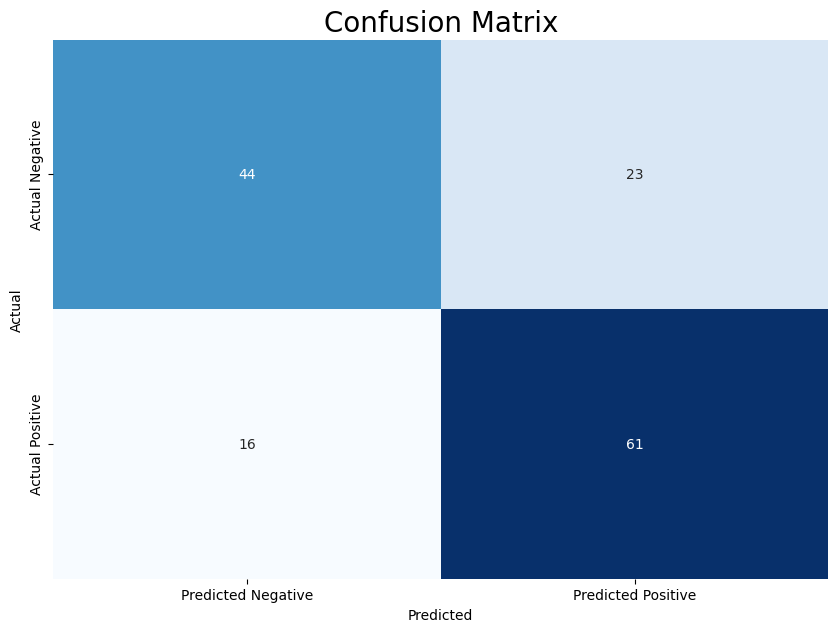

In [94]:
# посмотрим на матрицу ошибок
cm = confusion_matrix(y_test, predict_test)

# Создание тепловой карты
plt.figure(figsize=(10, 7))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()

Ошибки распределенеы практически равномерно, но модель тяготеет к ложному предсказыванию диабета у пациена, из 39 ошибочных предсказаний к этому типу ошибки относится 23.

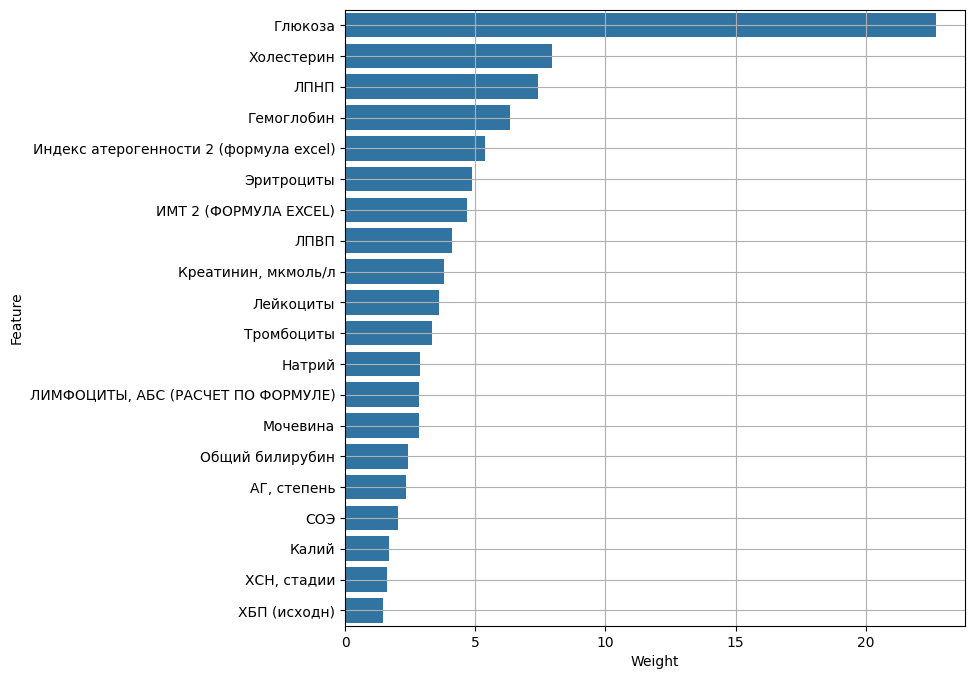

In [95]:
# посмотрим на веса модели
weights = model_best.feature_importances_
feature_weights = pd.DataFrame(
    {'Feature': [x for x in x_train_all.columns],
     'Weight': weights})
feature_weights.sort_values('Weight')

plt.subplots(figsize=(8, 8))
sns.barplot(feature_weights.sort_values(
    by='Weight', ascending=False).iloc[:20],
    x='Weight', y='Feature')
plt.grid(True)
plt.show()

Самый важный признак для модели - Глюкоза. Что в целом не удивительно, т.к. это один из основных анализов, на котоырй смотрят при определении сахарного диабета

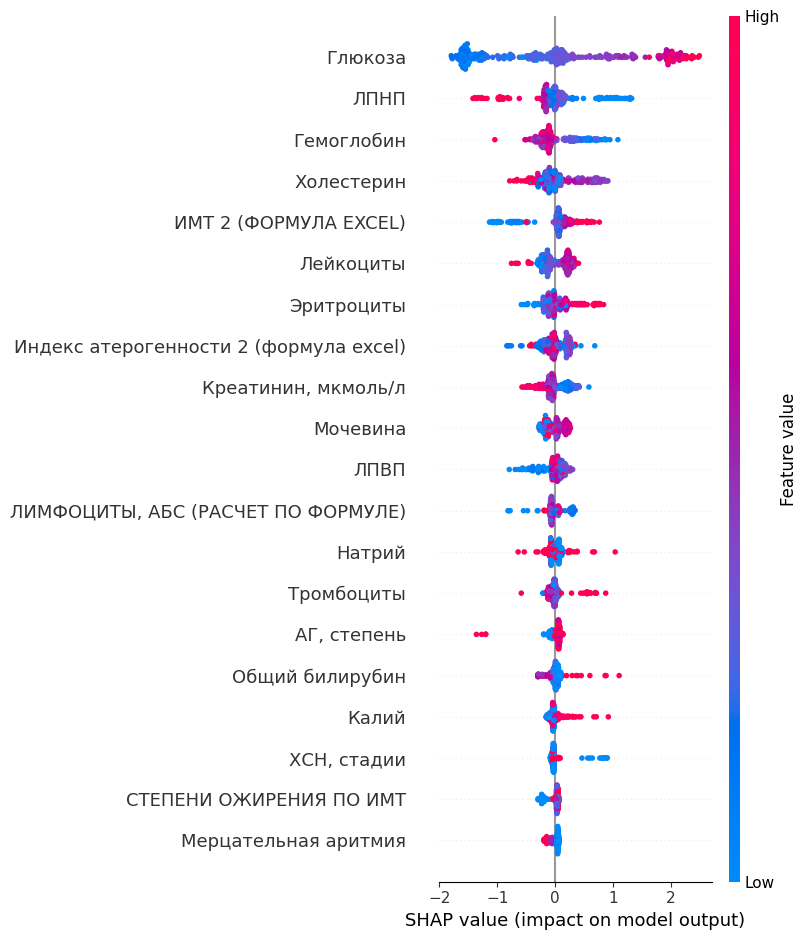

In [96]:
# посмотрим на распреедление весов в shap]

explainer = shap.TreeExplainer(model_best)
shap_values = explainer.shap_values(x_train_all)
shap.summary_plot(shap_values, x_train_all)

По весам полученным их shap видно что есть ещё много локальных вбросов по значениям, который были оставлены ранее при обработке данных. Так же видно что не все веса имеют четкое распределение между таргетами и часто пересекаются друг с другом.

In [97]:
# Построим lime
X_test_transformed_shap = pd.DataFrame(
    pipeline_transform.transform(x_test))
X_test_transformed_shap.columns = x_train_save_column

explainer = lime_tabular.LimeTabularExplainer(
    x_train_all.values, feature_names=x_train_all.columns,
    class_names=['0', '1'], discretize_continuous=True)
i = 128  # пример для интерпретации
exp = explainer.explain_instance(
    x_train_all.iloc[i], model_best.predict_proba,
    num_features=10)

exp.as_list()

[('ИМТ 2 (ФОРМУЛА EXCEL) <= 26.37', -0.11149661172728505),
 ('Эритроциты > 5.31', 0.08217289013823466),
 ('6.00 < Глюкоза <= 7.10', 0.07385445398474813),
 ('0.95 < ЛПВП <= 1.12', 0.04077212037100774),
 ('Гемоглобин > 160.00', -0.03691940000441835),
 ('Мерцательная аритмия > 1.00', -0.0345655753016643),
 ('АКШ <= 0.00', -0.03380725379449445),
 ('Холестерин <= 3.34', -0.0325944418068258),
 ('7.00 < СОЭ <= 12.00', -0.028360157994019627),
 ('1.69 < ЛПНП <= 2.15', 0.027332428350876257)]

In [98]:
exp.show_in_notebook()

Для примера взяли 128 строчку из трейна для анализа весов, тут немного картина отличается от весов shap, но суть остается такой же, по прежнему важными признаками остается Глюкоза ИМТ и т.д.

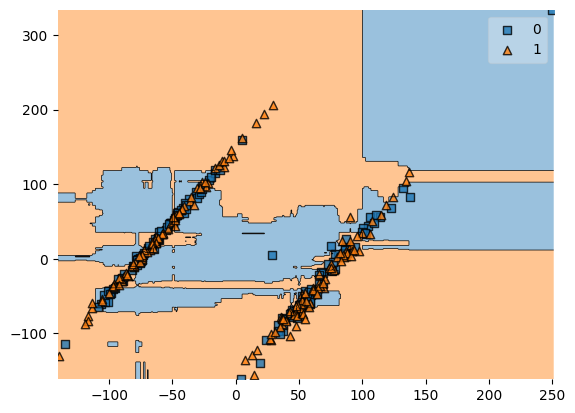

In [99]:
# изучим границы области решений классификатора
pca = PCA(n_components=2)
x_train_all_pca = pca.fit_transform(x_train_all)

reduced_model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)
reduced_model.fit(x_train_all_pca, y_train_all)

plot_decision_regions(
    X=x_train_all_pca, y=np.array(y_train_all), clf=reduced_model)
plt.show()


Разделяющая поверхность дерева показала нам, что данные трудно разделими и модель скорее заучивает ответы.

**Вывод:** Было првоедено финальное тестирование модели на тестовой выборке. Проведено исследование важности признаков и распределение весов у лучшей модели. Исследована разделяющая способность дерева.

<div style="border: 3px solid black; border-radius: 10px; padding: 10px;">

## ИТОГ

**Выполнено:**
- Загружены и подготолены данные
- Обработан и подготовлен датасет для подбора моделей
- Сформирована baseline модель
- Подобрана оптимальаня модель обучения
- Проведено финальное тестирование лучшей модели
- Исследован результат лучшей модели


В ходе исследования была выявлена лучшая модель -  CatBoostClassifier. Метрика на трейне при кросс-валидации составила 0.721, на тесте составила 0.725. Модель немного недообучилась, скорее всего ввиду малого кол-ва данных.

В ходе разработки моделей было сокращено большое кол-во колонок из первоначального датасета, на текущий момент модель принимает на вход датасет из 34 колонок (изначальный датасет состоит из 107). В целом данное кол-во можно ещё сильнее сократить при дальнейшем тюнинге модели.

В ходе подбора модели выбранная нами лишь немного превышает метрику, полученную при baseline, вероятно это из за размерности датасета.

В лучшей модели были определены самые важные признаки (топ 5): Глюкоза, Холестерин, ЛПНП, Гемоглобин, Индекс атерогенности 2.

Для презентации нашей модели, был разработан сервис streamlit.




</div>

In [100]:
# %%bash

# nbqa flake8 task_diabet_ds.ipynb

